In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, r2_score, confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import make_pipeline

In [2]:
# 관련 라이브러리 임포트 
import matplotlib
import matplotlib.font_manager as fm

# 한글글꼴로 변경
# plt.rcParams['font.family'] = '한글글꼴명'

# plt.rcParams['font.family'] = 'batang'
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 11.0

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
matplotlib.rcParams['axes.unicode_minus'] = False

# 그래프 기본 크기 설정 
plt.rcParams['figure.figsize'] = [10, 6]

# 쥬피터노트북의 숫자 변경 옵션
np.set_printoptions(precision=3, suppress=True)


- id: 데이터 고유 id
- age: 나이
- sex: 성별 (여자 = 0, 남자 = 1)
- cp: 가슴 통증(chest pain) 종류 
```
0 : asymptomatic 무증상
1 : atypical angina 일반적이지 않은 협심증
2 : non-anginal pain 협심증이 아닌 통증
3 : typical angina 일반적인 협심증
```
- trestbps: (resting blood pressure) 휴식 중 혈압(mmHg)
- chol: (serum cholestoral) 혈중 콜레스테롤 (mg/dl)
- fbs: (fasting blood sugar) 공복 중 혈당 (120 mg/dl 이하일 시 = 0, 초과일 시 = 1)
- restecg: (resting electrocardiographic) 휴식 중 심전도 결과 
```
0: showing probable or definite left ventricular hypertrophy by Estes' criteria
1: 정상
2: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
```
- thalach: (maximum heart rate achieved) 최대 심박수
- exang: (exercise induced angina) 활동으로 인한  협심증 여부 (없음 = 0, 있음 = 1)
- oldpeak: (ST depression induced by exercise relative to rest) 휴식 대비 운동으로 인한 ST 하강
- slope: (the slope of the peak exercise ST segment) 활동 ST 분절 피크의 기울기
```
0: downsloping 하강
1: flat 평탄
2: upsloping 상승
```
- ca: number of major vessels colored by flouroscopy 형광 투시로 확인된 주요 혈관 수 (0~3 개) 
```
Null 값은 숫자 4로 인코딩됨 
```
- thal: thalassemia 지중해빈혈 여부
```
0 = Null 
1 = normal 정상
2 = fixed defect 고정 결함
3 = reversable defect 가역 결함
```
- target: 심장 질환 진단 여부
```
0: < 50% diameter narrowing
1: > 50% diameter narrowing
```

In [13]:
df_train = pd.read_csv('dataset/train.csv', index_col='id')
df_train

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
id,,,,,,,,,,,,,,
1,53,1,2,130,197,1,0,152,0,1.2,0,0,2,1
2,52,1,3,152,298,1,1,178,0,1.2,1,0,3,1
3,54,1,1,192,283,0,0,195,0,0.0,2,1,3,0
4,45,0,0,138,236,0,0,152,1,0.2,1,0,2,1
5,35,1,1,122,192,0,1,174,0,0.0,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,50,1,2,140,233,0,1,163,0,0.6,1,1,3,0
148,51,1,2,94,227,0,1,154,1,0.0,2,1,3,1
149,69,1,3,160,234,1,0,131,0,0.1,1,1,2,1


In [298]:
df_test = pd.read_csv('dataset/test.csv', index_col='id')
df_test

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
id,,,,,,,,,,,,,
1,57,1,0,150,276,0,0,112,1,0.6,1,1,1
2,59,1,3,170,288,0,0,159,0,0.2,1,0,3
3,57,1,2,150,126,1,1,173,0,0.2,2,1,3
4,56,0,0,134,409,0,0,150,1,1.9,1,2,3
5,71,0,2,110,265,1,0,130,0,0.0,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,64,0,0,130,303,0,1,122,0,2.0,1,2,2
149,43,0,0,132,341,1,0,136,1,3.0,1,0,3
150,53,1,0,123,282,0,1,95,1,2.0,1,2,3


In [15]:
df_train.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,54.496689,0.682119,1.066225,132.033113,244.529801,0.158940,0.509934,150.629139,0.324503,0.976821,1.377483,0.602649,2.317881,0.549669
std,8.904586,0.467202,1.056213,17.909929,56.332206,0.366837,0.514685,23.466463,0.469747,1.085998,0.640226,0.917093,0.604107,0.499183
min,34.000000,0.000000,0.000000,94.000000,131.000000,0.000000,0.000000,88.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.500000,0.000000,0.000000,120.000000,208.000000,0.000000,0.000000,136.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,54.000000,1.000000,1.000000,130.000000,239.000000,0.000000,1.000000,155.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,270.000000,0.000000,1.000000,168.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,192.000000,564.000000,1.000000,2.000000,195.000000,1.000000,5.600000,2.000000,3.000000,3.000000,1.000000


In [16]:
df_train.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [155]:
df_train.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [17]:
df_train.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.093198,-0.142452,0.333521,0.222817,0.177720,-0.230188,-0.391406,0.181154,0.187196,-0.152385,0.339443,0.029941,-0.247806
sex,-0.093198,1.000000,-0.011094,-0.087967,-0.261557,0.024472,-0.042229,-0.010216,0.108632,0.141740,-0.064207,0.107782,0.242306,-0.246289
cp,-0.142452,-0.011094,1.000000,-0.002936,-0.016504,0.230745,-0.038009,0.251681,-0.379521,-0.128842,0.100808,-0.124067,-0.231730,0.436273
trestbps,0.333521,-0.087967,-0.002936,1.000000,0.187539,0.258959,-0.049577,-0.037929,0.103313,0.129670,-0.039470,0.078736,0.056325,-0.122850
chol,0.222817,-0.261557,-0.016504,0.187539,1.000000,0.057517,-0.146423,0.109218,-0.029214,0.096622,0.091094,0.049526,0.117261,0.036991
fbs,0.177720,0.024472,0.230745,0.258959,0.057517,1.000000,-0.079038,-0.005498,-0.069176,0.000942,-0.058464,0.089895,-0.049009,0.065821
restecg,-0.230188,-0.042229,-0.038009,-0.049577,-0.146423,-0.079038,1.000000,0.031770,0.055514,0.030829,-0.001340,-0.118697,0.096983,0.017528
thalach,-0.391406,-0.010216,0.251681,-0.037929,0.109218,-0.005498,0.031770,1.000000,-0.333734,-0.334791,0.267636,-0.203291,-0.079569,0.365249
exang,0.181154,0.108632,-0.379521,0.103313,-0.029214,-0.069176,0.055514,-0.333734,1.000000,0.319331,-0.254850,0.100126,0.221391,-0.396145
oldpeak,0.187196,0.141740,-0.128842,0.129670,0.096622,0.000942,0.030829,-0.334791,0.319331,1.000000,-0.564554,0.194849,0.269413,-0.421514


In [ ]:
매우 강한 양의 상관 관계 :
강한 양의 상관 관계 : cp, thalach, slope
약한 양의 상관 관계 : 
상관 관계 없음 : chol, fbs, restecg
약한 음의 상관 관계 : age, sex, trestbps
강한 음의 상관 관계 : exang, oldpeak, ca, thal
매우 강한 음의 상관 관계 : 

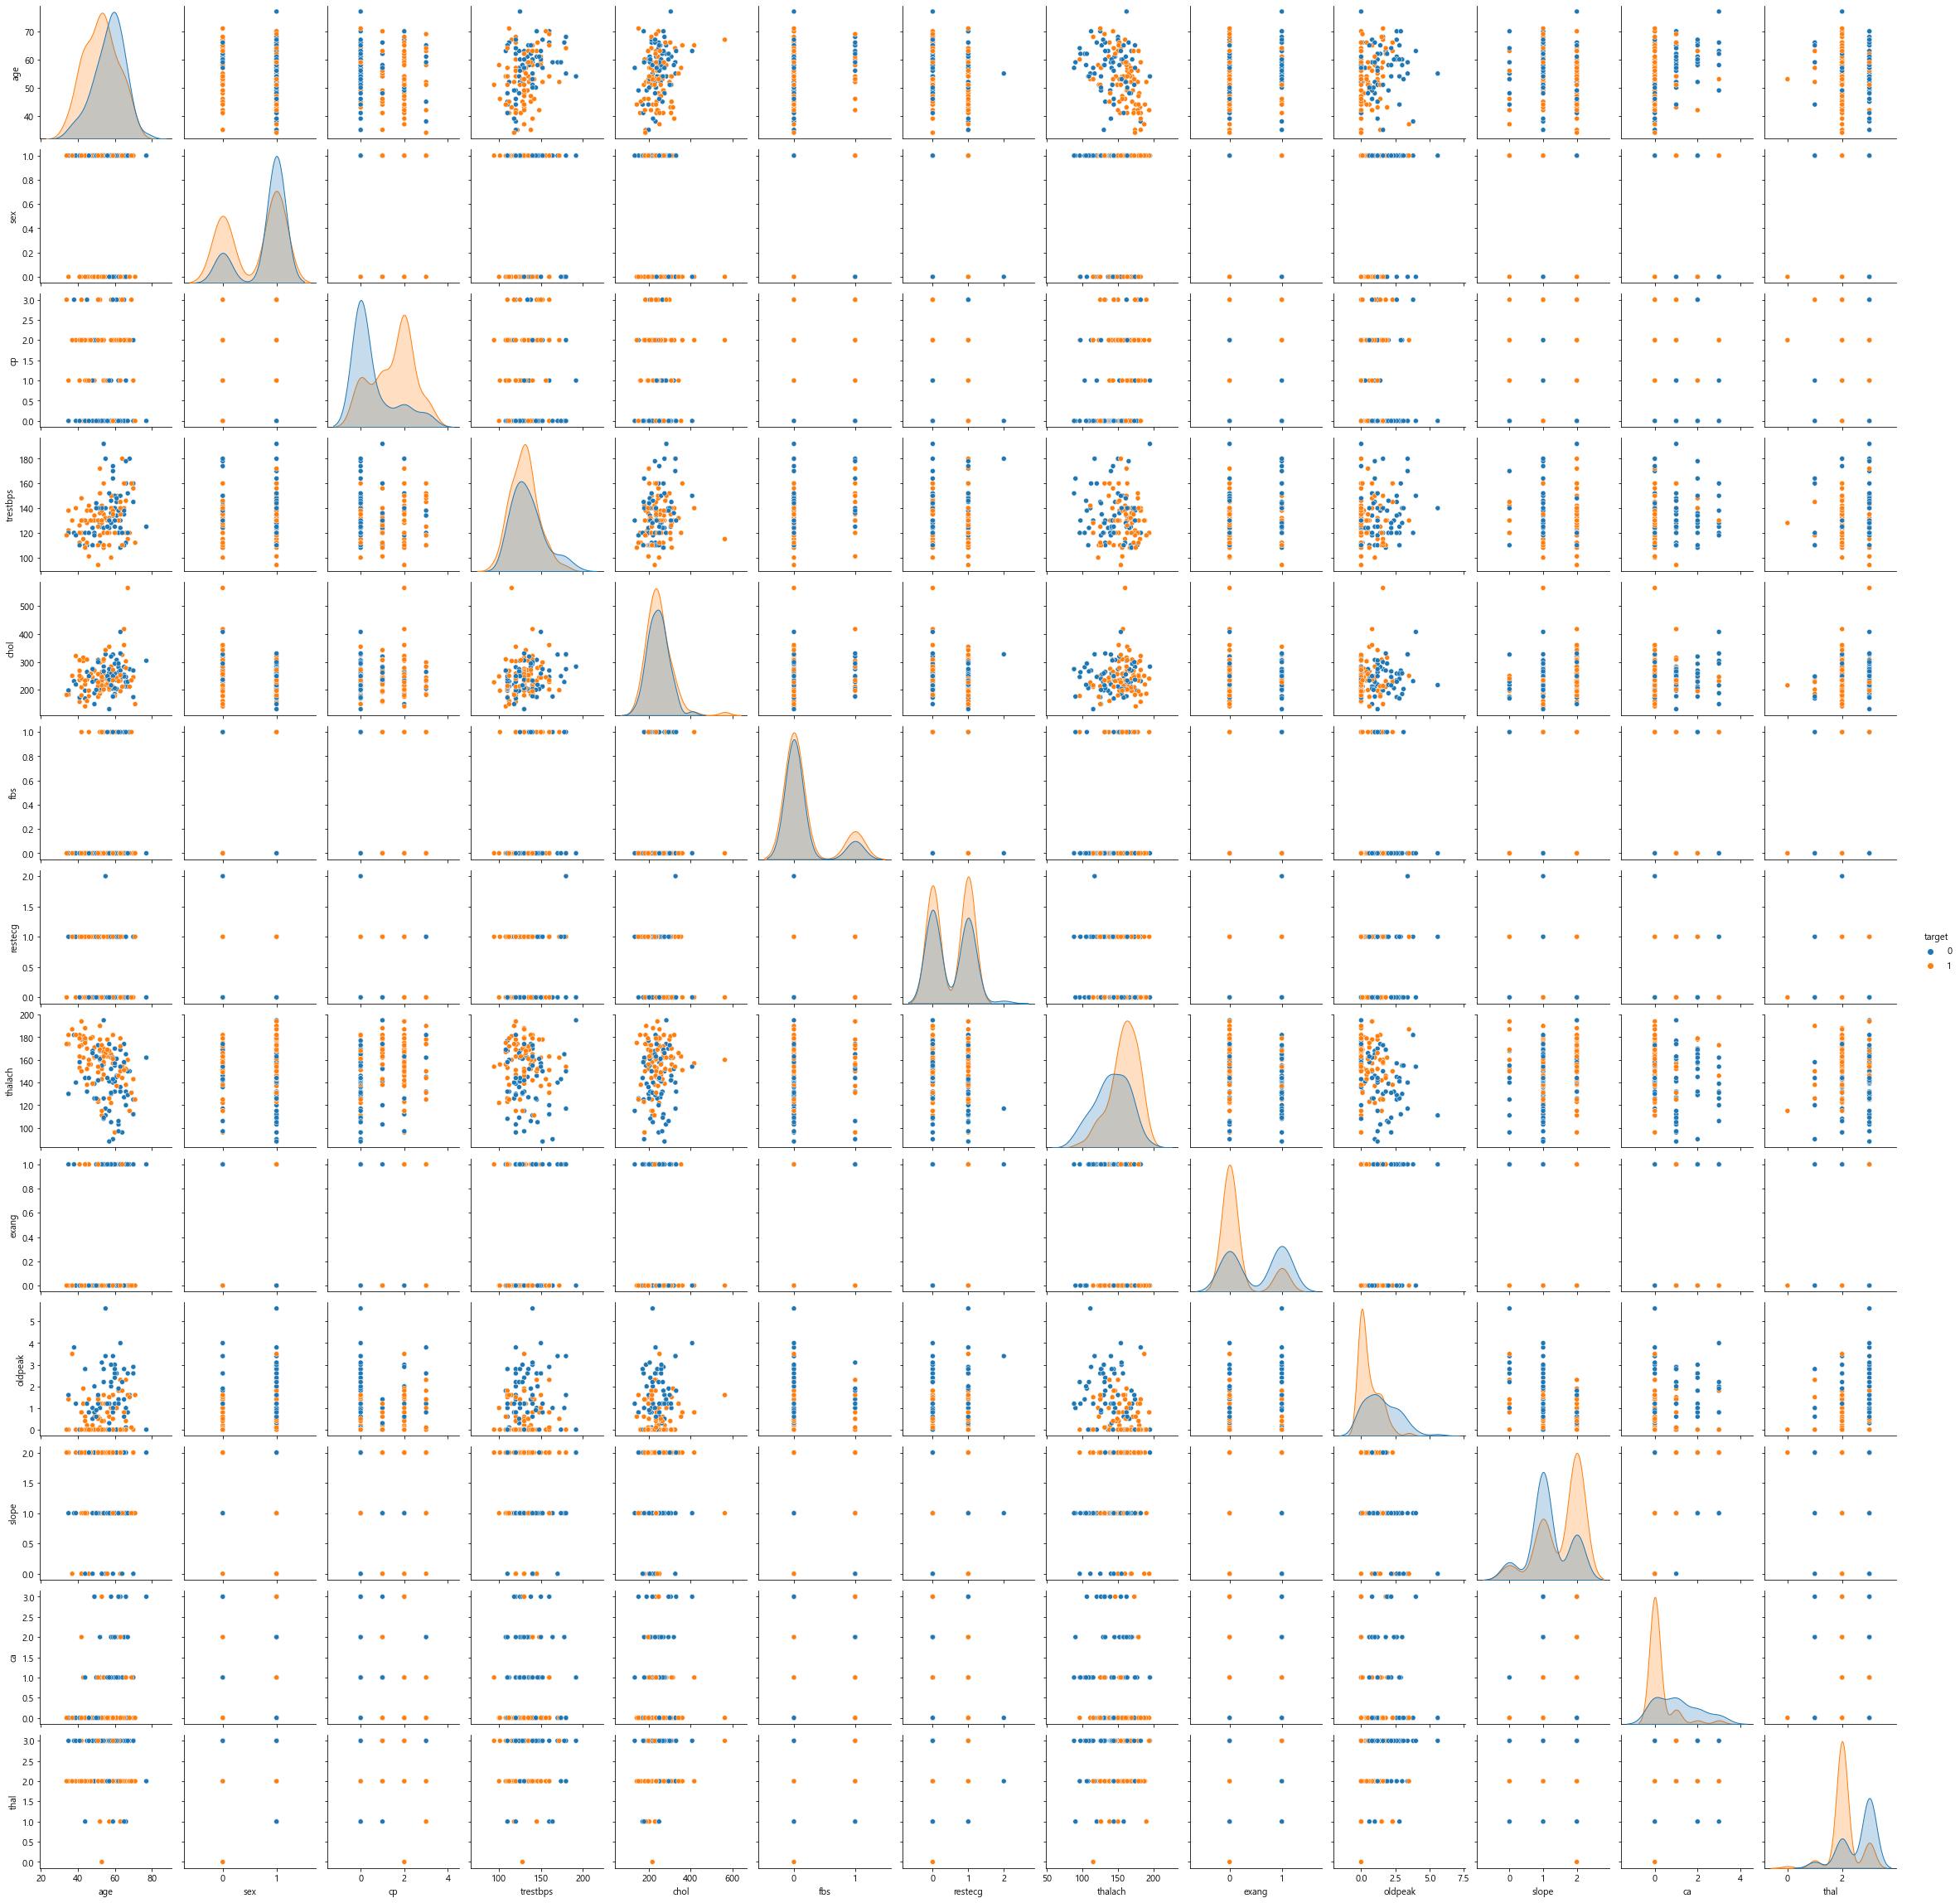

In [18]:
sns.pairplot(df_train, hue='target')

<AxesSubplot:>

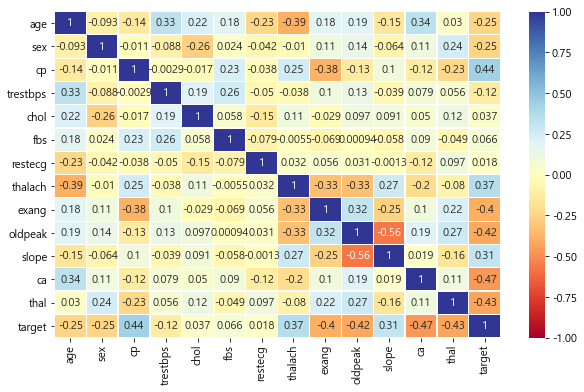

In [47]:
sns.heatmap(df_train.corr(), vmin=-1, vmax=1, annot=True, linewidths=0.2, cmap='RdYlBu')

<AxesSubplot:>

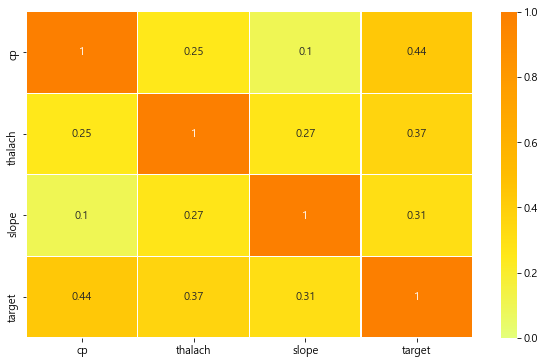

In [55]:
sns.heatmap(df_train[['cp', 'thalach', 'slope','target']].corr(), vmin=0, vmax=1, annot=True, linewidths=0.2, cmap='Wistia')

<AxesSubplot:>

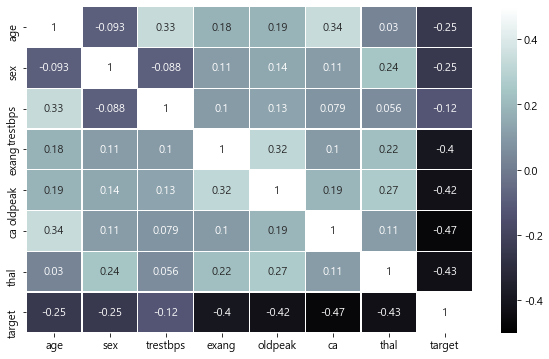

In [61]:
sns.heatmap(df_train[['age', 'sex', 'trestbps','exang', 'oldpeak', 'ca', 'thal','target']].corr(), vmin=-0.5, vmax=0.5, annot=True, linewidths=0.2, cmap='bone')

### 범주형, 수치형 분리

In [156]:
df_ca = df_train[['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']]
df_nu = df_train[['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'target']]

- 범주형
```
매우 강한 양의 상관 관계 :
강한 양의 상관 관계 : cp, slope
약한 양의 상관 관계 : 
상관 관계 없음 : fbs, restecg
약한 음의 상관 관계 : sex
강한 음의 상관 관계 : exang, ca, thal
매우 강한 음의 상관 관계 : 
```

In [157]:
df_ca.corr()

,sex,cp,fbs,restecg,exang,slope,ca,thal,target
sex,1.000000,-0.011094,0.024472,-0.042229,0.108632,-0.064207,0.107782,0.242306,-0.246289
cp,-0.011094,1.000000,0.230745,-0.038009,-0.379521,0.100808,-0.124067,-0.231730,0.436273
fbs,0.024472,0.230745,1.000000,-0.079038,-0.069176,-0.058464,0.089895,-0.049009,0.065821
restecg,-0.042229,-0.038009,-0.079038,1.000000,0.055514,-0.001340,-0.118697,0.096983,0.017528
exang,0.108632,-0.379521,-0.069176,0.055514,1.000000,-0.254850,0.100126,0.221391,-0.396145
slope,-0.064207,0.100808,-0.058464,-0.001340,-0.254850,1.000000,0.018723,-0.157188,0.305994
ca,0.107782,-0.124067,0.089895,-0.118697,0.100126,0.018723,1.000000,0.109176,-0.466289
thal,0.242306,-0.231730,-0.049009,0.096983,0.221391,-0.157188,0.109176,1.000000,-0.428530
target,-0.246289,0.436273,0.065821,0.017528,-0.396145,0.305994,-0.466289,-0.428530,1.000000


<AxesSubplot:>

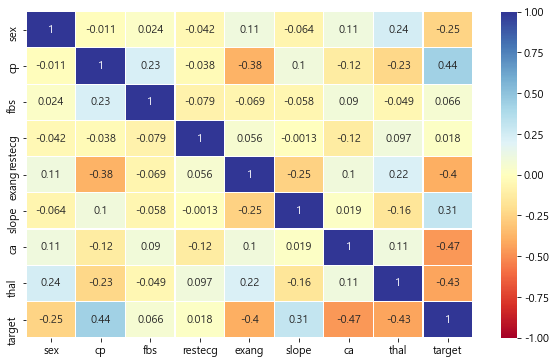

In [158]:
sns.heatmap(df_ca.corr(), vmin=-1, vmax=1, annot=True, linewidths=0.2, cmap='RdYlBu')

C:\Users\TFG5076XG\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\TFG5076XG\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


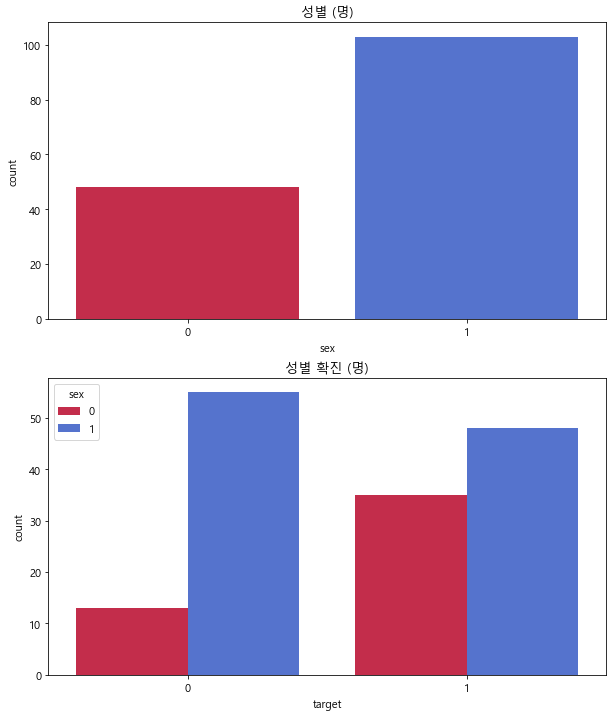

In [233]:
plt.figure(figsize=(10,12))
plt.subplot(2,1,1)
g0 = sns.countplot(df_ca.sex, palette={1: "royalblue", 0: "crimson"})
g0.set_title('성별 (명)');
plt.subplot(2,1,2)
g01 = sns.countplot(df_ca.target, hue=df_ca.sex, palette={1: "royalblue", 0: "crimson"})
g01.set_title('성별 확진 (명)');

C:\Users\TFG5076XG\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\TFG5076XG\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


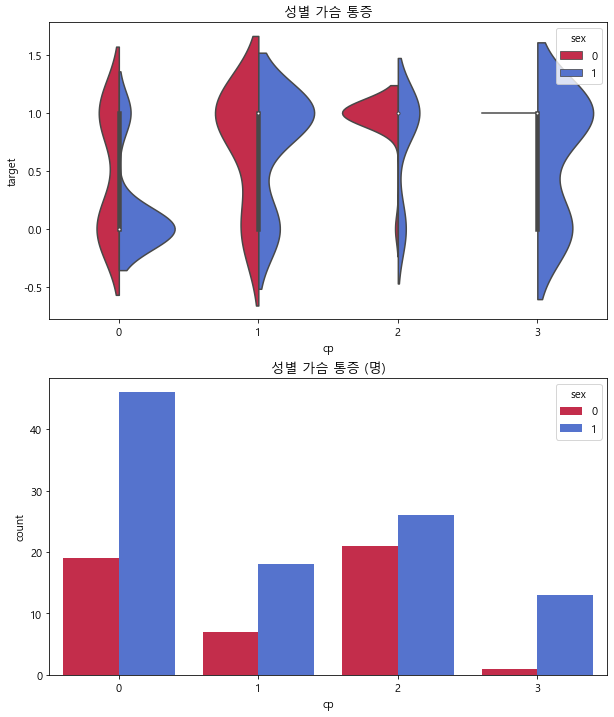

In [218]:
plt.figure(figsize=(10,12))
plt.subplot(2,1,1)
g1 =sns.violinplot(df_ca.cp, df_ca.target, hue=df_ca.sex,
              split=True,
              palette={1: "royalblue", 0: "crimson"})
g1.set_title('성별 가슴 통증');

plt.subplot(2,1,2)
g11 = sns.countplot(df_ca.cp, hue=df_ca.sex, palette={1: "royalblue", 0: "crimson"})
g11.set_title('성별 가슴 통증 (명)');
#plt.subplot(2,2,3)
#plt.subplot(2,2,4)



C:\Users\TFG5076XG\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\TFG5076XG\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


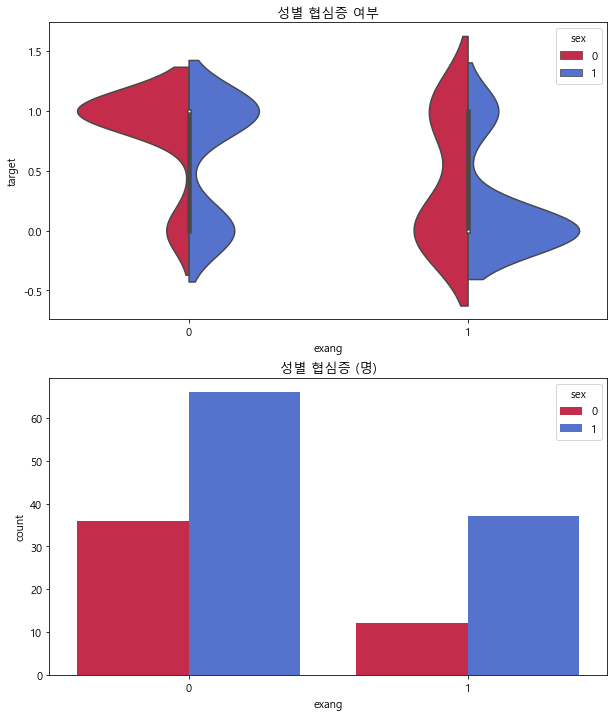

In [215]:
plt.figure(figsize=(10,12))
plt.subplot(2,1,1)
g2 =sns.violinplot(df_ca.exang, df_ca.target, hue=df_ca.sex,
              split=True,
              palette={1: "royalblue", 0: "crimson"})
g2.set_title('성별 협심증 여부');
plt.subplot(2,1,2)
g21 = sns.countplot(df_ca.exang, hue=df_ca.sex, palette={1: "royalblue", 0: "crimson"})
g21.set_title('성별 협심증 (명)');

C:\Users\TFG5076XG\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\TFG5076XG\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


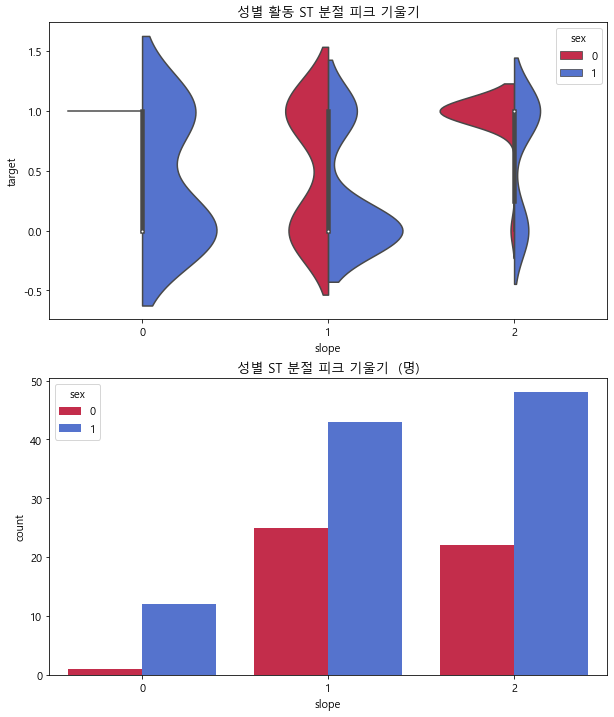

In [214]:
plt.figure(figsize=(10,12))
plt.subplot(2,1,1)
g3 =sns.violinplot(df_ca.slope, df_ca.target, hue=df_ca.sex,
              split=True,
              palette={1: "royalblue", 0: "crimson"})
g3.set_title('성별 활동 ST 분절 피크 기울기');
plt.subplot(2,1,2)
g31 = sns.countplot(df_ca.slope, hue=df_ca.sex, palette={1: "royalblue", 0: "crimson"})
g31.set_title('성별 ST 분절 피크 기울기  (명)');

C:\Users\TFG5076XG\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\TFG5076XG\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


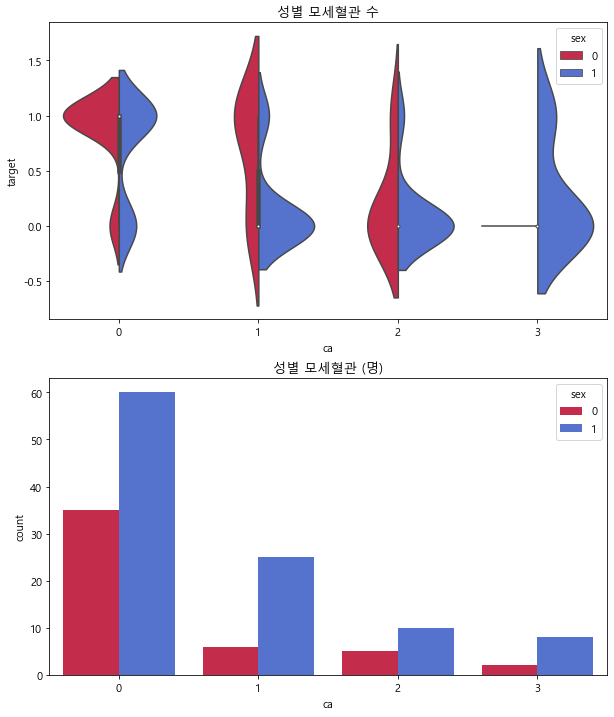

In [217]:
plt.figure(figsize=(10,12))
plt.subplot(2,1,1)
g4 =sns.violinplot(df_ca.ca, df_ca.target, hue=df_ca.sex,
              split=True,
              palette={1: "royalblue", 0: "crimson"})
g4.set_title('성별 모세혈관 수');
plt.subplot(2,1,2)
g41 = sns.countplot(df_ca.ca, hue=df_ca.sex, palette={1: "royalblue", 0: "crimson"})
g41.set_title('성별 모세혈관 (명)');

C:\Users\TFG5076XG\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\TFG5076XG\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


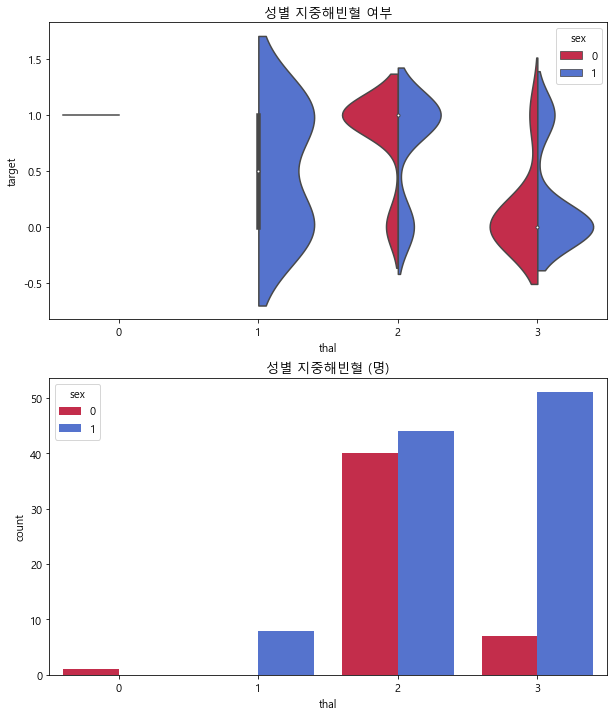

In [219]:
plt.figure(figsize=(10,12))
plt.subplot(2,1,1)
g5 =sns.violinplot(df_ca.thal, df_ca.target, hue=df_ca.sex,
              split=True,
              palette={1: "royalblue", 0: "crimson"})
g5.set_title('성별 지중해빈혈 여부');
plt.subplot(2,1,2)
g51 = sns.countplot(df_ca.thal, hue=df_ca.sex, palette={1: "royalblue", 0: "crimson"})
g51.set_title('성별 지중해빈혈 (명)');

C:\Users\TFG5076XG\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\TFG5076XG\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


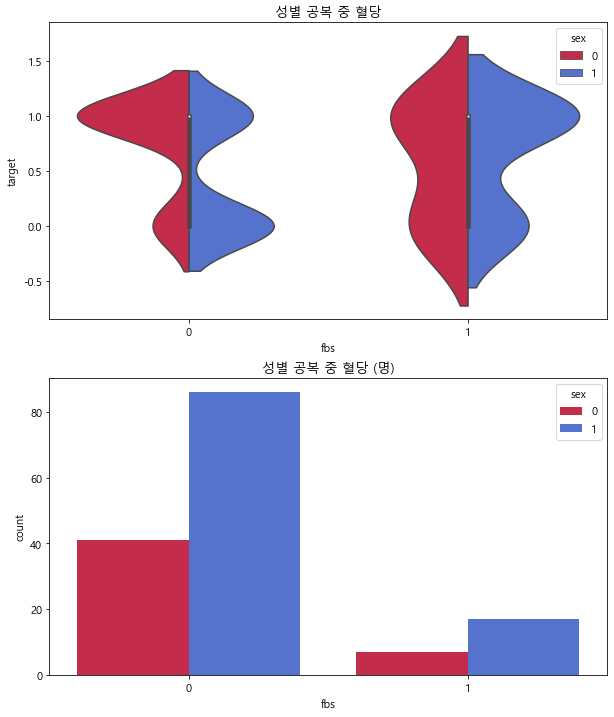

In [220]:
plt.figure(figsize=(10,12))
plt.subplot(2,1,1)
g6 =sns.violinplot(df_ca.fbs, df_ca.target, hue=df_ca.sex,
              split=True,
              palette={1: "royalblue", 0: "crimson"})
g6.set_title('성별 공복 중 혈당');
plt.subplot(2,1,2)
g61 = sns.countplot(df_ca.fbs, hue=df_ca.sex, palette={1: "royalblue", 0: "crimson"})
g61.set_title('성별 공복 중 혈당 (명)');

C:\Users\TFG5076XG\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\TFG5076XG\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


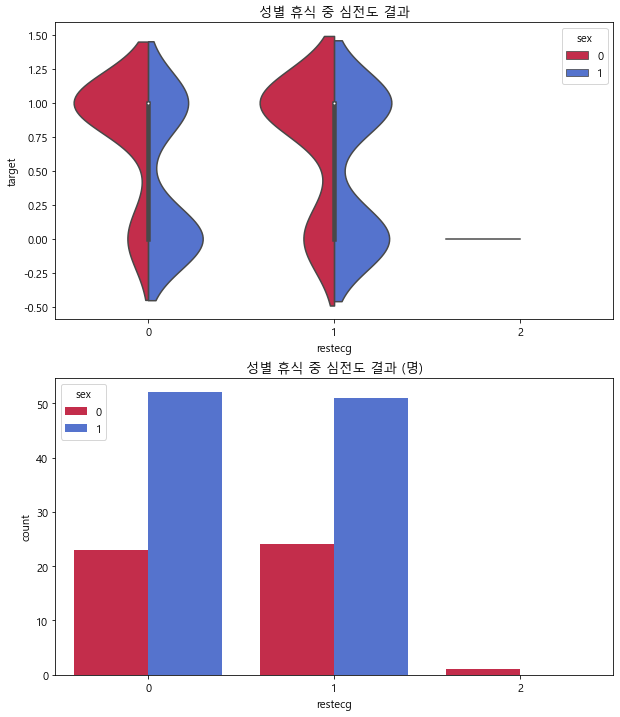

In [221]:
plt.figure(figsize=(10,12))
plt.subplot(2,1,1)
g7 =sns.violinplot(df_ca.restecg, df_ca.target, hue=df_ca.sex,
              split=True,
              palette={1: "royalblue", 0: "crimson"})
g7.set_title('성별 휴식 중 심전도 결과');
plt.subplot(2,1,2)
g71 = sns.countplot(df_ca.restecg, hue=df_ca.sex, palette={1: "royalblue", 0: "crimson"})
g71.set_title('성별 휴식 중 심전도 결과 (명)');

- 수치형
```
매우 강한 양의 상관 관계 :
강한 양의 상관 관계 : thalach
약한 양의 상관 관계 : 
상관 관계 없음 : chol
약한 음의 상관 관계 : age, trestbps
강한 음의 상관 관계 : oldpeak
매우 강한 음의 상관 관계 : 
```

In [160]:
df_nu.corr()

,age,trestbps,chol,thalach,oldpeak,target
age,1.000000,0.333521,0.222817,-0.391406,0.187196,-0.247806
trestbps,0.333521,1.000000,0.187539,-0.037929,0.129670,-0.122850
chol,0.222817,0.187539,1.000000,0.109218,0.096622,0.036991
thalach,-0.391406,-0.037929,0.109218,1.000000,-0.334791,0.365249
oldpeak,0.187196,0.129670,0.096622,-0.334791,1.000000,-0.421514
target,-0.247806,-0.122850,0.036991,0.365249,-0.421514,1.000000


<AxesSubplot:>

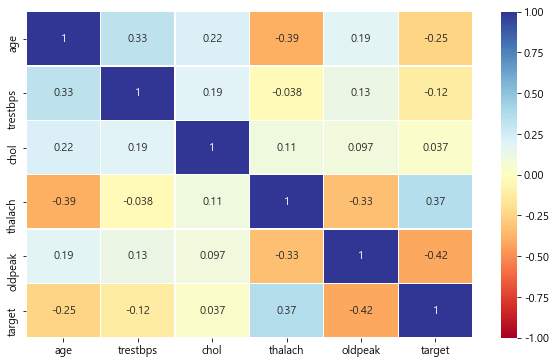

In [159]:
sns.heatmap(df_nu.corr(), vmin=-1, vmax=1, annot=True, linewidths=0.2, cmap='RdYlBu')

- n x n 이 hist 즉, 데이터의 분포를 보여준다...

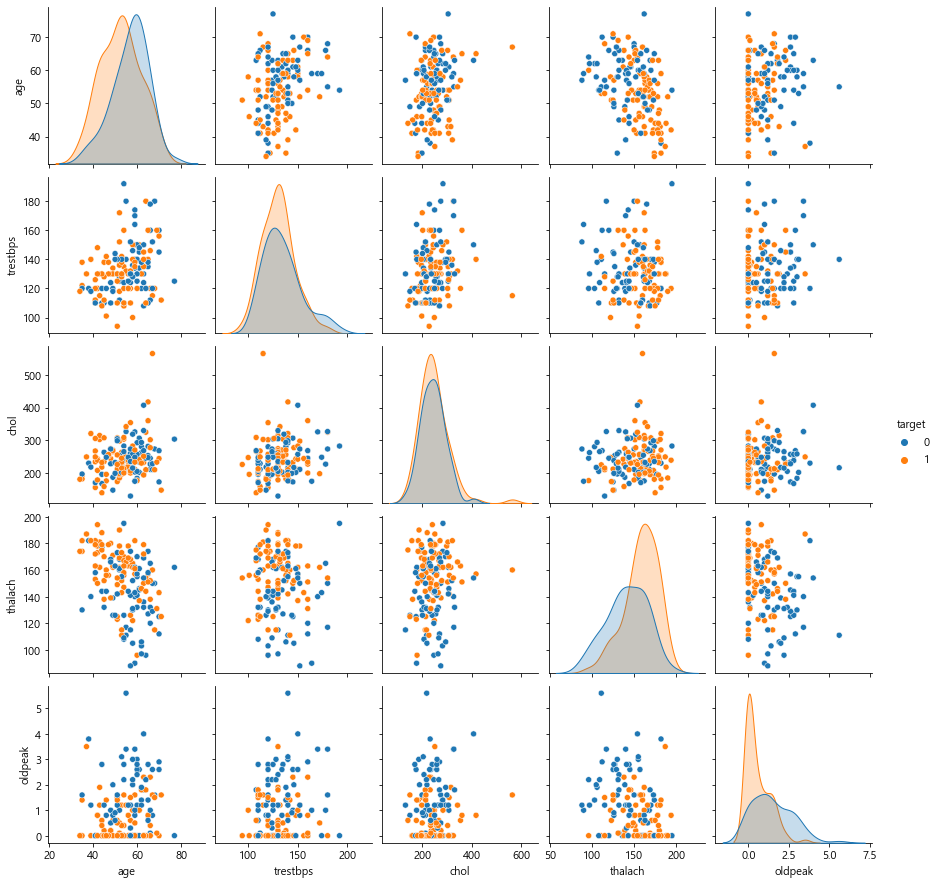

In [162]:
sns.pairplot(df_nu, hue='target')

<AxesSubplot:xlabel='oldpeak', ylabel='Count'>

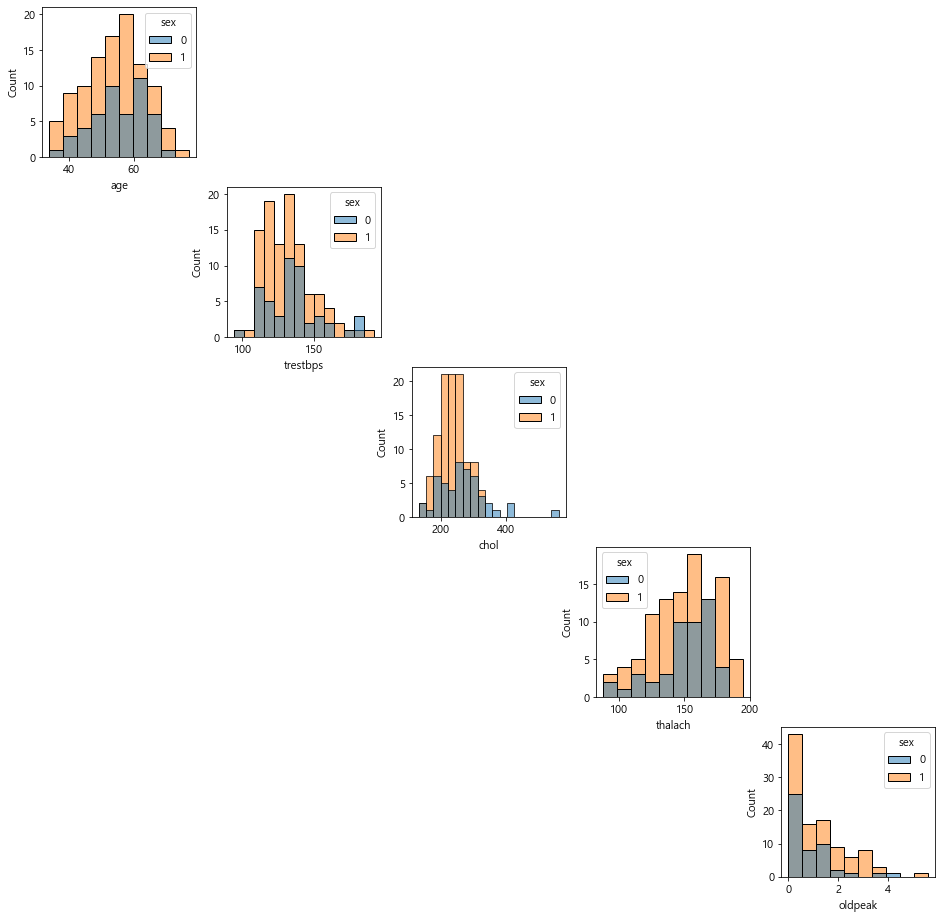

In [467]:
plt.figure(figsize=(16,16))
plt.subplot(5,5,1)
sns.histplot(df_train, x='age', hue='sex')
plt.subplot(5,5,7)
sns.histplot(df_train, x='trestbps', hue='sex')
plt.subplot(5,5,13)
sns.histplot(df_train, x='chol', hue='sex')
plt.subplot(5,5,19)
sns.histplot(df_train, x='thalach', hue='sex')
plt.subplot(5,5,25)
sns.histplot(df_train, x='oldpeak', hue='sex')


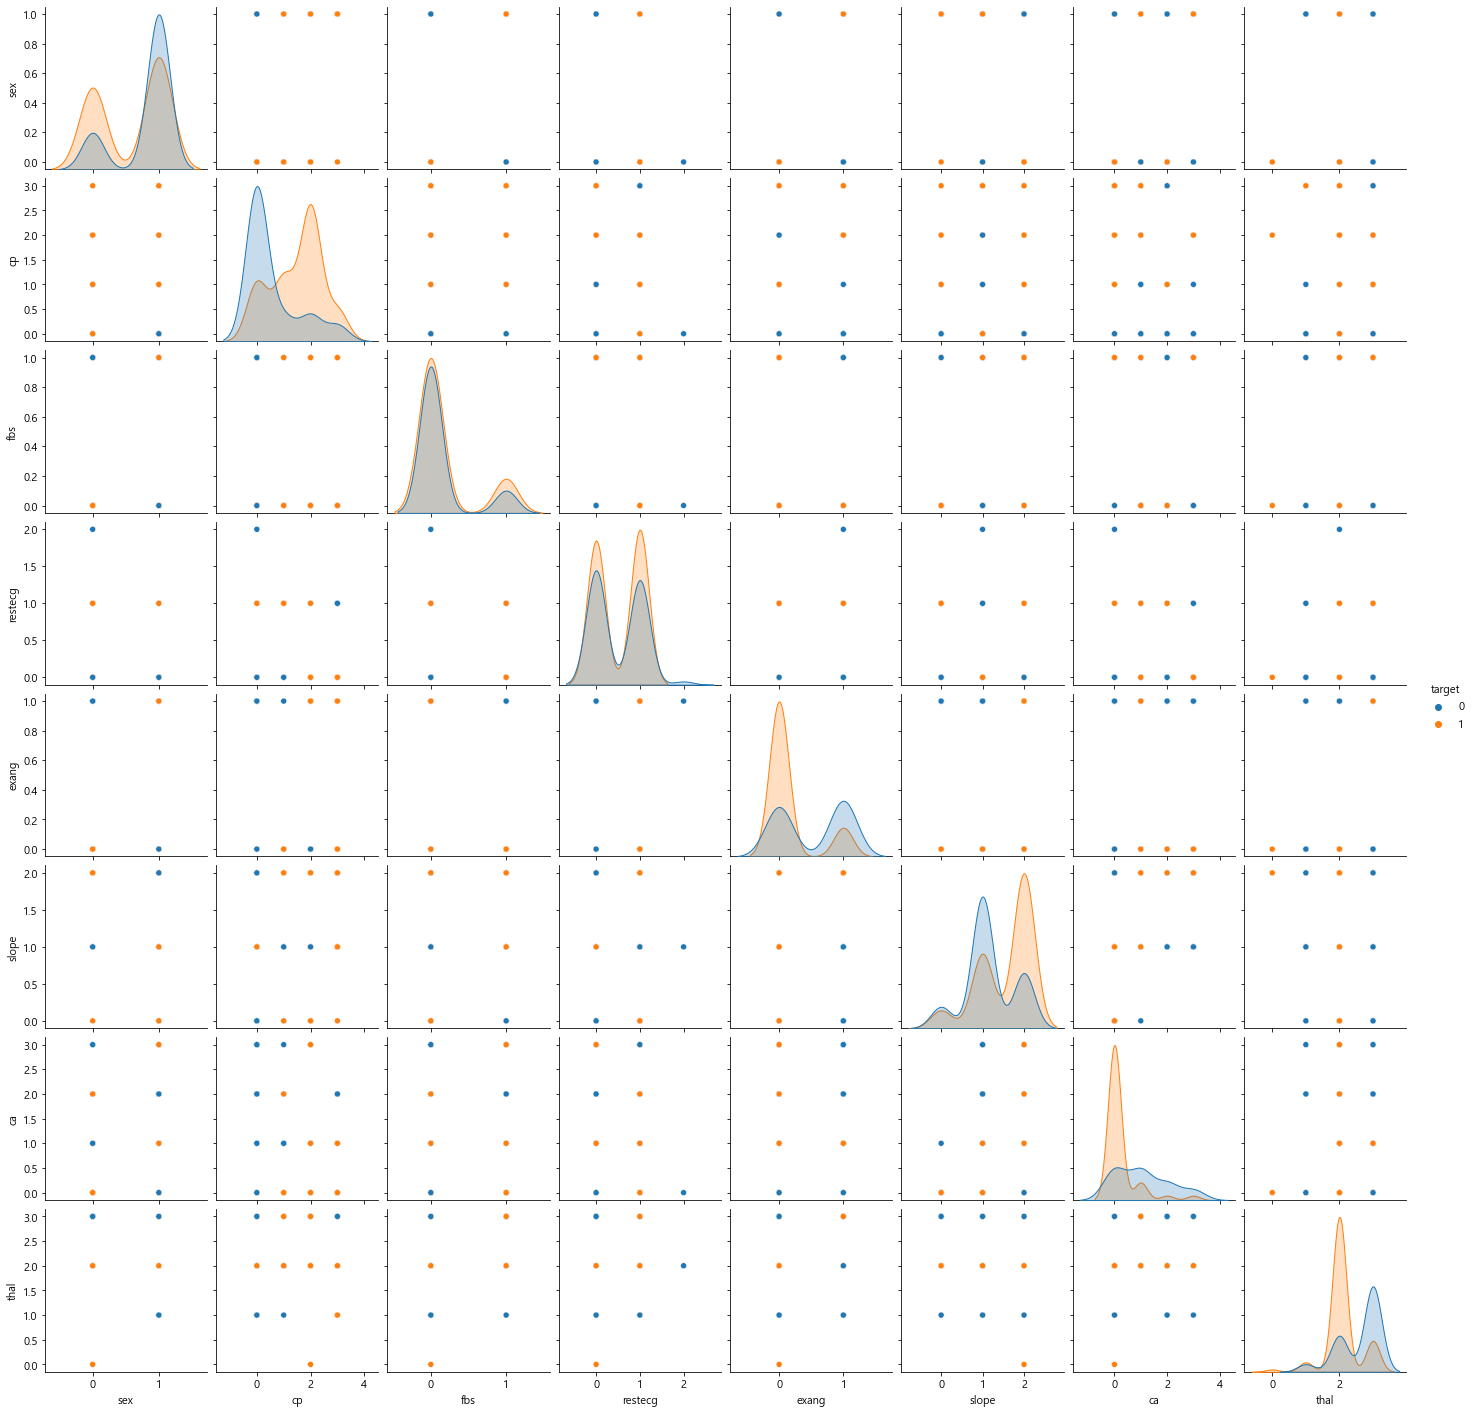

In [473]:
sns.pairplot(df_ca, hue='target')

- 범주형 hist는 이상하다...?

<AxesSubplot:xlabel='thal', ylabel='Count'>

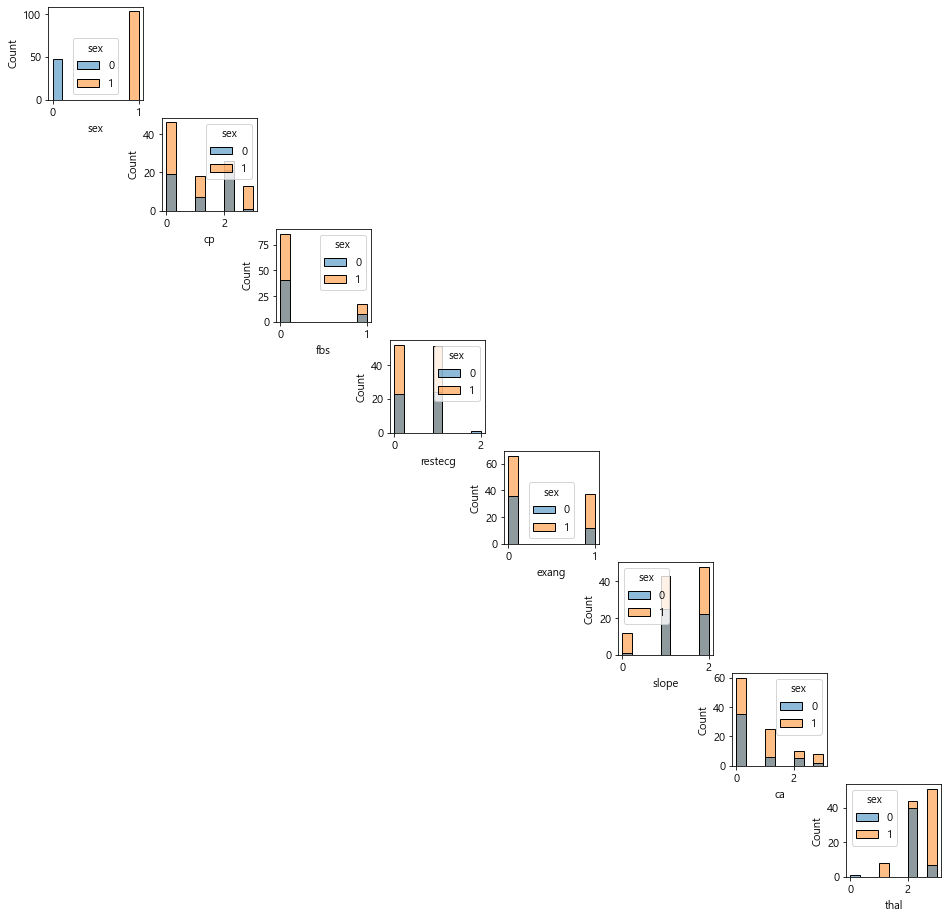

In [474]:
plt.figure(figsize=(16,16))
plt.subplot(8,8,1)
sns.histplot(df_train, x='sex', hue='sex')
plt.subplot(8,8,10)
sns.histplot(df_train, x='cp', hue='sex')
plt.subplot(8,8,19)
sns.histplot(df_train, x='fbs', hue='sex')
plt.subplot(8,8,28)
sns.histplot(df_train, x='restecg', hue='sex')
plt.subplot(8,8,37)
sns.histplot(df_train, x='exang', hue='sex')
plt.subplot(8,8,46)
sns.histplot(df_train, x='slope', hue='sex')
plt.subplot(8,8,55)
sns.histplot(df_train, x='ca', hue='sex')
plt.subplot(8,8,64)
sns.histplot(df_train, x='thal', hue='sex')


## 데이터 전처리
#### train

- 범주형은 One Hot

In [409]:
ca_label = pd.get_dummies(df_ca, columns=['sex','cp', 'exang', 'slope', 'ca', 'thal'])
x_train = ca_label.iloc[:,3:]
y_train = ca_label.target

In [410]:
x_train.shape, y_train.shape

((151, 19), (151,))

- 수치(연속)형은 MinMax

In [411]:
df_nu.describe()

,age,trestbps,chol,thalach,oldpeak,target
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,54.496689,132.033113,244.529801,150.629139,0.976821,0.549669
std,8.904586,17.909929,56.332206,23.466463,1.085998,0.499183
min,34.000000,94.000000,131.000000,88.000000,0.000000,0.000000
25%,48.500000,120.000000,208.000000,136.500000,0.000000,0.000000
50%,54.000000,130.000000,239.000000,155.000000,0.800000,1.000000
75%,61.000000,140.000000,270.000000,168.000000,1.600000,1.000000
max,77.000000,192.000000,564.000000,195.000000,5.600000,1.000000


In [412]:
encoder = MinMaxScaler()
nu_scaled = encoder.fit_transform(df_nu.iloc[:,[0,1,3,4]])

In [413]:
nu_scaled

array([[0.442, 0.367, 0.598, 0.214],
       [0.419, 0.592, 0.841, 0.214],
       [0.465, 1.   , 1.   , 0.   ],
       [0.256, 0.449, 0.598, 0.036],
       [0.023, 0.286, 0.804, 0.   ],
       [0.349, 0.265, 0.477, 0.357],
       [0.163, 0.163, 0.607, 0.   ],
       [0.605, 0.469, 0.626, 0.536],
       [0.488, 0.469, 0.215, 1.   ],
       [0.023, 0.449, 0.879, 0.25 ],
       [0.791, 0.878, 0.579, 0.286],
       [0.767, 0.214, 0.673, 0.286],
       [0.721, 0.418, 0.364, 0.5  ],
       [0.512, 0.367, 0.701, 0.   ],
       [0.349, 0.367, 0.776, 0.107],
       [0.279, 0.49 , 0.673, 0.25 ],
       [0.721, 0.469, 0.645, 0.143],
       [0.186, 0.265, 0.794, 0.   ],
       [0.581, 0.776, 0.486, 0.607],
       [0.349, 0.408, 0.692, 0.   ],
       [0.651, 0.265, 0.14 , 0.25 ],
       [0.744, 0.265, 0.589, 0.071],
       [0.442, 0.49 , 0.215, 0.   ],
       [0.628, 0.52 , 0.542, 0.179],
       [0.837, 0.52 , 0.346, 0.464],
       [0.326, 0.367, 0.86 , 0.036],
       [0.558, 0.061, 0.318, 0.179],
 

In [414]:
x_train[['age','trestbps','thalach','oldpeak']] = nu_scaled

In [415]:
x_train

,sex_0,sex_1,cp_0,cp_1,cp_2,cp_3,exang_0,exang_1,slope_0,slope_1,...,ca_2,ca_3,thal_0,thal_1,thal_2,thal_3,age,trestbps,thalach,oldpeak
id,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,1,0,1,0,1,0,...,0,0,0,0,1,0,0.441860,0.367347,0.598131,0.214286
2,0,1,0,0,0,1,1,0,0,1,...,0,0,0,0,0,1,0.418605,0.591837,0.841121,0.214286
3,0,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0.465116,1.000000,1.000000,0.000000
4,1,0,1,0,0,0,0,1,0,1,...,0,0,0,0,1,0,0.255814,0.448980,0.598131,0.035714
5,0,1,0,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0.023256,0.285714,0.803738,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,0,1,0,0,1,0,1,0,0,1,...,0,0,0,0,0,1,0.372093,0.469388,0.700935,0.107143
148,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0.395349,0.000000,0.616822,0.000000
149,0,1,0,0,0,1,1,0,0,1,...,0,0,0,0,1,0,0.813953,0.673469,0.401869,0.017857


#### test

In [299]:
df_test.shape

(152, 13)

In [300]:
test_ca = df_test[['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']]
test_nu = df_test[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']]

In [301]:
test_ca_label = pd.get_dummies(test_ca, columns=['sex','cp', 'exang', 'slope', 'ca', 'thal'])
x_test = test_ca_label.iloc[:,3:]

In [302]:
x_test.shape

(152, 19)

In [303]:
x_test

,sex_1,cp_0,cp_1,cp_2,cp_3,exang_0,exang_1,slope_0,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
id,,,,,,,,,,,,,,,,,,,
1,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0
2,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,1
3,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1
4,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1
5,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0
149,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1
150,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1


In [304]:
test_nu_scaled = encoder.fit_transform(test_nu.iloc[:,[0,1,3,4]])

In [305]:
x_test[['age','trestbps','thalach','oldpeak']] = test_nu_scaled

In [306]:
x_test

,sex_1,cp_0,cp_1,cp_2,cp_3,exang_0,exang_1,slope_0,slope_1,slope_2,...,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3,age,trestbps,thalach,oldpeak
id,,,,,,,,,,,,,,,,,,,,,
1,1,1,0,0,0,0,1,0,1,0,...,0,0,0,1,0,0,0.595745,0.528302,0.312977,0.096774
2,1,0,0,0,1,1,0,0,1,0,...,0,0,0,0,0,1,0.638298,0.716981,0.671756,0.032258
3,1,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,1,0.595745,0.528302,0.778626,0.032258
4,0,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0.574468,0.377358,0.603053,0.306452
5,0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,1,0,0.893617,0.150943,0.450382,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0.744681,0.339623,0.389313,0.322581
149,0,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0.297872,0.358491,0.496183,0.483871
150,1,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0.510638,0.273585,0.183206,0.322581


#### 모델 학습

In [416]:
dense = Dense(units=1, input_dim=23, activation='sigmoid')
model=Sequential([dense])
model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
earlystop = EarlyStopping(monitor='loss', patience=200, min_delta=0.001)
h1=model.fit(x_train, y_train, epochs=10000, callbacks=[earlystop])

Epoch 1/10000
5/5 [==============================] - 0s 1ms/step - loss: 0.6172 - accuracy: 0.6689
Epoch 2/10000
5/5 [==============================] - 0s 206us/step - loss: 0.6122 - accuracy: 0.6755
Epoch 3/10000
5/5 [==============================] - 0s 1ms/step - loss: 0.6074 - accuracy: 0.6755
Epoch 4/10000
5/5 [==============================] - 0s 428us/step - loss: 0.6030 - accuracy: 0.6887
Epoch 5/10000
5/5 [==============================] - 0s 640us/step - loss: 0.5984 - accuracy: 0.7020
Epoch 6/10000
5/5 [==============================] - 0s 598us/step - loss: 0.5938 - accuracy: 0.7219
Epoch 7/10000
5/5 [==============================] - 0s 598us/step - loss: 0.5896 - accuracy: 0.7285
Epoch 8/10000
5/5 [==============================] - 0s 398us/step - loss: 0.5853 - accuracy: 0.7285
Epoch 9/10000
5/5 [==============================] - 0s 399us/step - loss: 0.5810 - accuracy: 0.7285
Epoch 10/10000
5/5 [==============================] - 0s 399us/step - loss: 0.5772 - accuracy: 

5/5 [==============================] - 0s 597us/step - loss: 0.4099 - accuracy: 0.8477
Epoch 82/10000
5/5 [==============================] - 0s 399us/step - loss: 0.4086 - accuracy: 0.8477
Epoch 83/10000
5/5 [==============================] - 0s 399us/step - loss: 0.4073 - accuracy: 0.8477
Epoch 84/10000
5/5 [==============================] - 0s 399us/step - loss: 0.4061 - accuracy: 0.8477
Epoch 85/10000
5/5 [==============================] - 0s 399us/step - loss: 0.4049 - accuracy: 0.8477
Epoch 86/10000
5/5 [==============================] - 0s 598us/step - loss: 0.4036 - accuracy: 0.8477
Epoch 87/10000
5/5 [==============================] - 0s 399us/step - loss: 0.4025 - accuracy: 0.8477
Epoch 88/10000
5/5 [==============================] - 0s 399us/step - loss: 0.4013 - accuracy: 0.8477
Epoch 89/10000
5/5 [==============================] - 0s 399us/step - loss: 0.4002 - accuracy: 0.8477
Epoch 90/10000
5/5 [==============================] - 0s 399us/step - loss: 0.3990 - accuracy: 0.

5/5 [==============================] - 0s 399us/step - loss: 0.3454 - accuracy: 0.8543
Epoch 161/10000
5/5 [==============================] - 0s 598us/step - loss: 0.3449 - accuracy: 0.8543
Epoch 162/10000
5/5 [==============================] - 0s 399us/step - loss: 0.3444 - accuracy: 0.8543
Epoch 163/10000
5/5 [==============================] - 0s 399us/step - loss: 0.3439 - accuracy: 0.8543
Epoch 164/10000
5/5 [==============================] - 0s 399us/step - loss: 0.3434 - accuracy: 0.8543
Epoch 165/10000
5/5 [==============================] - 0s 399us/step - loss: 0.3429 - accuracy: 0.8543
Epoch 166/10000
5/5 [==============================] - 0s 399us/step - loss: 0.3424 - accuracy: 0.8543
Epoch 167/10000
5/5 [==============================] - 0s 399us/step - loss: 0.3419 - accuracy: 0.8609
Epoch 168/10000
5/5 [==============================] - 0s 399us/step - loss: 0.3414 - accuracy: 0.8609
Epoch 169/10000
5/5 [==============================] - 0s 399us/step - loss: 0.3410 - acc

5/5 [==============================] - 0s 399us/step - loss: 0.3153 - accuracy: 0.8675
Epoch 240/10000
5/5 [==============================] - 0s 599us/step - loss: 0.3150 - accuracy: 0.8675
Epoch 241/10000
5/5 [==============================] - 0s 399us/step - loss: 0.3147 - accuracy: 0.8675
Epoch 242/10000
5/5 [==============================] - 0s 399us/step - loss: 0.3144 - accuracy: 0.8675
Epoch 243/10000
5/5 [==============================] - 0s 199us/step - loss: 0.3142 - accuracy: 0.8675
Epoch 244/10000
5/5 [==============================] - 0s 399us/step - loss: 0.3139 - accuracy: 0.8675
Epoch 245/10000
5/5 [==============================] - 0s 399us/step - loss: 0.3136 - accuracy: 0.8675
Epoch 246/10000
5/5 [==============================] - 0s 399us/step - loss: 0.3134 - accuracy: 0.8675
Epoch 247/10000
5/5 [==============================] - 0s 199us/step - loss: 0.3131 - accuracy: 0.8675
Epoch 248/10000
5/5 [==============================] - 0s 399us/step - loss: 0.3128 - acc

5/5 [==============================] - 0s 399us/step - loss: 0.2972 - accuracy: 0.8742
Epoch 319/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2970 - accuracy: 0.8742
Epoch 320/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2968 - accuracy: 0.8742
Epoch 321/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2966 - accuracy: 0.8742
Epoch 322/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2964 - accuracy: 0.8742
Epoch 323/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2962 - accuracy: 0.8742
Epoch 324/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2961 - accuracy: 0.8742
Epoch 325/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2959 - accuracy: 0.8742
Epoch 326/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2957 - accuracy: 0.8742
Epoch 327/10000
5/5 [==============================] - 0s 598us/step - loss: 0.2955 - acc

5/5 [==============================] - 0s 399us/step - loss: 0.2850 - accuracy: 0.8742
Epoch 398/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2848 - accuracy: 0.8742
Epoch 399/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2847 - accuracy: 0.8742
Epoch 400/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2845 - accuracy: 0.8742
Epoch 401/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2844 - accuracy: 0.8742
Epoch 402/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2843 - accuracy: 0.8742
Epoch 403/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2841 - accuracy: 0.8742
Epoch 404/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2840 - accuracy: 0.8742
Epoch 405/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2839 - accuracy: 0.8742
Epoch 406/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2838 - acc

5/5 [==============================] - 0s 399us/step - loss: 0.2760 - accuracy: 0.8742
Epoch 477/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2760 - accuracy: 0.8742
Epoch 478/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2758 - accuracy: 0.8742
Epoch 479/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2758 - accuracy: 0.8742
Epoch 480/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2756 - accuracy: 0.8742
Epoch 481/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2755 - accuracy: 0.8742
Epoch 482/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2754 - accuracy: 0.8742
Epoch 483/10000
5/5 [==============================] - 0s 598us/step - loss: 0.2754 - accuracy: 0.8742
Epoch 484/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2753 - accuracy: 0.8742
Epoch 485/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2752 - acc

5/5 [==============================] - 0s 598us/step - loss: 0.2693 - accuracy: 0.8742
Epoch 556/10000
5/5 [==============================] - 0s 599us/step - loss: 0.2692 - accuracy: 0.8742
Epoch 557/10000
5/5 [==============================] - 0s 598us/step - loss: 0.2691 - accuracy: 0.8742
Epoch 558/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2691 - accuracy: 0.8742
Epoch 559/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2690 - accuracy: 0.8808
Epoch 560/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2690 - accuracy: 0.8808
Epoch 561/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2688 - accuracy: 0.8808
Epoch 562/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2688 - accuracy: 0.8808
Epoch 563/10000
5/5 [==============================] - 0s 199us/step - loss: 0.2687 - accuracy: 0.8808
Epoch 564/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2687 - acc

5/5 [==============================] - 0s 399us/step - loss: 0.2641 - accuracy: 0.8808
Epoch 635/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2640 - accuracy: 0.8808
Epoch 636/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2640 - accuracy: 0.8808
Epoch 637/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2639 - accuracy: 0.8808
Epoch 638/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2638 - accuracy: 0.8808
Epoch 639/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2638 - accuracy: 0.8808
Epoch 640/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2638 - accuracy: 0.8808
Epoch 641/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2637 - accuracy: 0.8808
Epoch 642/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2636 - accuracy: 0.8808
Epoch 643/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2636 - acc

5/5 [==============================] - 0s 399us/step - loss: 0.2599 - accuracy: 0.8808
Epoch 714/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2599 - accuracy: 0.8808
Epoch 715/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2599 - accuracy: 0.8808
Epoch 716/10000
5/5 [==============================] - 0s 199us/step - loss: 0.2598 - accuracy: 0.8808
Epoch 717/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2597 - accuracy: 0.8808
Epoch 718/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2597 - accuracy: 0.8808
Epoch 719/10000
5/5 [==============================] - 0s 598us/step - loss: 0.2597 - accuracy: 0.8808
Epoch 720/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2596 - accuracy: 0.8808
Epoch 721/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2596 - accuracy: 0.8808
Epoch 722/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2595 - acc

5/5 [==============================] - 0s 399us/step - loss: 0.2566 - accuracy: 0.8808
Epoch 793/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2566 - accuracy: 0.8808
Epoch 794/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2565 - accuracy: 0.8874
Epoch 795/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2565 - accuracy: 0.8874
Epoch 796/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2565 - accuracy: 0.8874
Epoch 797/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2564 - accuracy: 0.8808
Epoch 798/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2564 - accuracy: 0.8874
Epoch 799/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2564 - accuracy: 0.8808
Epoch 800/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2563 - accuracy: 0.8808
Epoch 801/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2563 - acc

5/5 [==============================] - 0s 399us/step - loss: 0.2539 - accuracy: 0.8874
Epoch 872/10000
5/5 [==============================] - 0s 199us/step - loss: 0.2538 - accuracy: 0.8874
Epoch 873/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2538 - accuracy: 0.8874
Epoch 874/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2538 - accuracy: 0.8874
Epoch 875/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2537 - accuracy: 0.8874
Epoch 876/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2537 - accuracy: 0.8874
Epoch 877/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2537 - accuracy: 0.8874
Epoch 878/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2538 - accuracy: 0.8874
Epoch 879/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2537 - accuracy: 0.8874
Epoch 880/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2536 - acc

5/5 [==============================] - 0s 399us/step - loss: 0.2516 - accuracy: 0.8874
Epoch 951/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2516 - accuracy: 0.8874
Epoch 952/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2516 - accuracy: 0.8874
Epoch 953/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2515 - accuracy: 0.8874
Epoch 954/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2515 - accuracy: 0.8874
Epoch 955/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2515 - accuracy: 0.8874
Epoch 956/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2515 - accuracy: 0.8874
Epoch 957/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2514 - accuracy: 0.8874
Epoch 958/10000
5/5 [==============================] - 0s 199us/step - loss: 0.2514 - accuracy: 0.8874
Epoch 959/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2514 - acc

5/5 [==============================] - 0s 399us/step - loss: 0.2497 - accuracy: 0.8940
Epoch 1030/10000
5/5 [==============================] - 0s 598us/step - loss: 0.2497 - accuracy: 0.8940
Epoch 1031/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2496 - accuracy: 0.8940
Epoch 1032/10000
5/5 [==============================] - 0s 598us/step - loss: 0.2496 - accuracy: 0.8940
Epoch 1033/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2496 - accuracy: 0.8940
Epoch 1034/10000
5/5 [==============================] - 0s 398us/step - loss: 0.2496 - accuracy: 0.8940
Epoch 1035/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2496 - accuracy: 0.8940
Epoch 1036/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2495 - accuracy: 0.8940
Epoch 1037/10000
5/5 [==============================] - 0s 598us/step - loss: 0.2495 - accuracy: 0.8940
Epoch 1038/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2

Epoch 1108/10000
5/5 [==============================] - 0s 598us/step - loss: 0.2481 - accuracy: 0.8940
Epoch 1109/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2480 - accuracy: 0.8940
Epoch 1110/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2480 - accuracy: 0.8940
Epoch 1111/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2480 - accuracy: 0.8940
Epoch 1112/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2480 - accuracy: 0.8940
Epoch 1113/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2479 - accuracy: 0.8940
Epoch 1114/10000
5/5 [==============================] - 0s 598us/step - loss: 0.2479 - accuracy: 0.8940
Epoch 1115/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2479 - accuracy: 0.8940
Epoch 1116/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2479 - accuracy: 0.8940
Epoch 1117/10000
5/5 [==============================] - 0s 399us

5/5 [==============================] - 0s 399us/step - loss: 0.2466 - accuracy: 0.8874
Epoch 1187/10000
5/5 [==============================] - 0s 595us/step - loss: 0.2466 - accuracy: 0.8874
Epoch 1188/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2466 - accuracy: 0.8874
Epoch 1189/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2466 - accuracy: 0.8874
Epoch 1190/10000
5/5 [==============================] - 0s 598us/step - loss: 0.2466 - accuracy: 0.8874
Epoch 1191/10000
5/5 [==============================] - 0s 400us/step - loss: 0.2466 - accuracy: 0.8874
Epoch 1192/10000
5/5 [==============================] - 0s 598us/step - loss: 0.2465 - accuracy: 0.8874
Epoch 1193/10000
5/5 [==============================] - 0s 599us/step - loss: 0.2465 - accuracy: 0.8874
Epoch 1194/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2465 - accuracy: 0.8874
Epoch 1195/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2

Epoch 1265/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2454 - accuracy: 0.8874
Epoch 1266/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2454 - accuracy: 0.8874
Epoch 1267/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2454 - accuracy: 0.8874
Epoch 1268/10000
5/5 [==============================] - 0s 395us/step - loss: 0.2453 - accuracy: 0.8874
Epoch 1269/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2453 - accuracy: 0.8874
Epoch 1270/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2453 - accuracy: 0.8874
Epoch 1271/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2453 - accuracy: 0.8874
Epoch 1272/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2453 - accuracy: 0.8874
Epoch 1273/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2453 - accuracy: 0.8874
Epoch 1274/10000
5/5 [==============================] - 0s 399us

5/5 [==============================] - 0s 199us/step - loss: 0.2443 - accuracy: 0.8874
Epoch 1344/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2443 - accuracy: 0.8874
Epoch 1345/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2443 - accuracy: 0.8874
Epoch 1346/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2443 - accuracy: 0.8874
Epoch 1347/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2443 - accuracy: 0.8874
Epoch 1348/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2443 - accuracy: 0.8874
Epoch 1349/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2442 - accuracy: 0.8874
Epoch 1350/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2443 - accuracy: 0.8874
Epoch 1351/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2442 - accuracy: 0.8874
Epoch 1352/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2

Epoch 1422/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2434 - accuracy: 0.8874
Epoch 1423/10000
5/5 [==============================] - 0s 598us/step - loss: 0.2433 - accuracy: 0.8874
Epoch 1424/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2433 - accuracy: 0.8874
Epoch 1425/10000
5/5 [==============================] - 0s 598us/step - loss: 0.2433 - accuracy: 0.8874
Epoch 1426/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2433 - accuracy: 0.8874
Epoch 1427/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2433 - accuracy: 0.8874
Epoch 1428/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2433 - accuracy: 0.8874
Epoch 1429/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2433 - accuracy: 0.8874
Epoch 1430/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2432 - accuracy: 0.8874
Epoch 1431/10000
5/5 [==============================] - 0s 399us

5/5 [==============================] - 0s 399us/step - loss: 0.2425 - accuracy: 0.8874
Epoch 1501/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2425 - accuracy: 0.8874
Epoch 1502/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2425 - accuracy: 0.8874
Epoch 1503/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2424 - accuracy: 0.8874
Epoch 1504/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2424 - accuracy: 0.8874
Epoch 1505/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2424 - accuracy: 0.8874
Epoch 1506/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2424 - accuracy: 0.8874
Epoch 1507/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2424 - accuracy: 0.8874
Epoch 1508/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2424 - accuracy: 0.8874
Epoch 1509/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2

Epoch 1579/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2417 - accuracy: 0.8874
Epoch 1580/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2417 - accuracy: 0.8874
Epoch 1581/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2417 - accuracy: 0.8874
Epoch 1582/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2417 - accuracy: 0.8874
Epoch 1583/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2416 - accuracy: 0.8874
Epoch 1584/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2416 - accuracy: 0.8874
Epoch 1585/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2416 - accuracy: 0.8874
Epoch 1586/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2416 - accuracy: 0.8874
Epoch 1587/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2416 - accuracy: 0.8874
Epoch 1588/10000
5/5 [==============================] - 0s 399us

5/5 [==============================] - 0s 399us/step - loss: 0.2410 - accuracy: 0.8874
Epoch 1658/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2410 - accuracy: 0.8874
Epoch 1659/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2410 - accuracy: 0.8874
Epoch 1660/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2410 - accuracy: 0.8874
Epoch 1661/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2410 - accuracy: 0.8874
Epoch 1662/10000
5/5 [==============================] - 0s 598us/step - loss: 0.2410 - accuracy: 0.8874
Epoch 1663/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2409 - accuracy: 0.8874
Epoch 1664/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2409 - accuracy: 0.8874
Epoch 1665/10000
5/5 [==============================] - 0s 598us/step - loss: 0.2409 - accuracy: 0.8874
Epoch 1666/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2

Epoch 1736/10000
5/5 [==============================] - 0s 598us/step - loss: 0.2403 - accuracy: 0.8940
Epoch 1737/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2404 - accuracy: 0.8940
Epoch 1738/10000
5/5 [==============================] - 0s 396us/step - loss: 0.2403 - accuracy: 0.8940
Epoch 1739/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2403 - accuracy: 0.8940
Epoch 1740/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2403 - accuracy: 0.8940
Epoch 1741/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2403 - accuracy: 0.8940
Epoch 1742/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2403 - accuracy: 0.8940
Epoch 1743/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2403 - accuracy: 0.8940
Epoch 1744/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2402 - accuracy: 0.8940
Epoch 1745/10000
5/5 [==============================] - 0s 399us

5/5 [==============================] - 0s 399us/step - loss: 0.2397 - accuracy: 0.8940
Epoch 1815/10000
5/5 [==============================] - 0s 688us/step - loss: 0.2397 - accuracy: 0.8940
Epoch 1816/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2397 - accuracy: 0.8940
Epoch 1817/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2397 - accuracy: 0.8940
Epoch 1818/10000
5/5 [==============================] - 0s 598us/step - loss: 0.2397 - accuracy: 0.8940
Epoch 1819/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2397 - accuracy: 0.8940
Epoch 1820/10000
5/5 [==============================] - 0s 599us/step - loss: 0.2397 - accuracy: 0.8940
Epoch 1821/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2397 - accuracy: 0.8940
Epoch 1822/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2397 - accuracy: 0.8940
Epoch 1823/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2

Epoch 1893/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2392 - accuracy: 0.8940
Epoch 1894/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2392 - accuracy: 0.8940
Epoch 1895/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2392 - accuracy: 0.8940
Epoch 1896/10000
5/5 [==============================] - 0s 598us/step - loss: 0.2392 - accuracy: 0.8940
Epoch 1897/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2393 - accuracy: 0.8940
Epoch 1898/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2392 - accuracy: 0.8940
Epoch 1899/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2392 - accuracy: 0.8940
Epoch 1900/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2393 - accuracy: 0.8940
Epoch 1901/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2391 - accuracy: 0.8940
Epoch 1902/10000
5/5 [==============================] - 0s 399us

5/5 [==============================] - 0s 399us/step - loss: 0.2387 - accuracy: 0.8940
Epoch 1972/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2387 - accuracy: 0.8940
Epoch 1973/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2387 - accuracy: 0.8940
Epoch 1974/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2387 - accuracy: 0.8940
Epoch 1975/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2387 - accuracy: 0.8940
Epoch 1976/10000
5/5 [==============================] - 0s 598us/step - loss: 0.2387 - accuracy: 0.8940
Epoch 1977/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2387 - accuracy: 0.8940
Epoch 1978/10000
5/5 [==============================] - 0s 599us/step - loss: 0.2387 - accuracy: 0.8940
Epoch 1979/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2387 - accuracy: 0.8940
Epoch 1980/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2

Epoch 2050/10000
5/5 [==============================] - 0s 598us/step - loss: 0.2383 - accuracy: 0.8940
Epoch 2051/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2384 - accuracy: 0.8940
Epoch 2052/10000
5/5 [==============================] - 0s 598us/step - loss: 0.2383 - accuracy: 0.8940
Epoch 2053/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2383 - accuracy: 0.8940
Epoch 2054/10000
5/5 [==============================] - 0s 598us/step - loss: 0.2383 - accuracy: 0.8940
Epoch 2055/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2383 - accuracy: 0.8940
Epoch 2056/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2383 - accuracy: 0.8940
Epoch 2057/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2383 - accuracy: 0.8940
Epoch 2058/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2383 - accuracy: 0.8940
Epoch 2059/10000
5/5 [==============================] - 0s 199us

5/5 [==============================] - 0s 399us/step - loss: 0.2379 - accuracy: 0.8940
Epoch 2129/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2379 - accuracy: 0.8940
Epoch 2130/10000
5/5 [==============================] - 0s 599us/step - loss: 0.2379 - accuracy: 0.8940
Epoch 2131/10000
5/5 [==============================] - 0s 599us/step - loss: 0.2378 - accuracy: 0.8940
Epoch 2132/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2378 - accuracy: 0.8940
Epoch 2133/10000
5/5 [==============================] - 0s 798us/step - loss: 0.2378 - accuracy: 0.8940
Epoch 2134/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2378 - accuracy: 0.8940
Epoch 2135/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2378 - accuracy: 0.8940
Epoch 2136/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2378 - accuracy: 0.8940
Epoch 2137/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2

Epoch 2207/10000
5/5 [==============================] - 0s 396us/step - loss: 0.2375 - accuracy: 0.8940
Epoch 2208/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2374 - accuracy: 0.8940
Epoch 2209/10000
5/5 [==============================] - 0s 200us/step - loss: 0.2375 - accuracy: 0.8940
Epoch 2210/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2375 - accuracy: 0.8940
Epoch 2211/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2375 - accuracy: 0.8940
Epoch 2212/10000
5/5 [==============================] - 0s 199us/step - loss: 0.2374 - accuracy: 0.8940
Epoch 2213/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2375 - accuracy: 0.8940
Epoch 2214/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2375 - accuracy: 0.8940
Epoch 2215/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2374 - accuracy: 0.8940
Epoch 2216/10000
5/5 [==============================] - 0s 399us

5/5 [==============================] - 0s 399us/step - loss: 0.2371 - accuracy: 0.8940
Epoch 2286/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2371 - accuracy: 0.8940
Epoch 2287/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2371 - accuracy: 0.8940
Epoch 2288/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2371 - accuracy: 0.8940
Epoch 2289/10000
5/5 [==============================] - 0s 598us/step - loss: 0.2371 - accuracy: 0.8940
Epoch 2290/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2371 - accuracy: 0.8940
Epoch 2291/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2371 - accuracy: 0.8940
Epoch 2292/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2371 - accuracy: 0.8940
Epoch 2293/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2371 - accuracy: 0.8940
Epoch 2294/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2

Epoch 2364/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2368 - accuracy: 0.8940
Epoch 2365/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2368 - accuracy: 0.8940
Epoch 2366/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2367 - accuracy: 0.8940
Epoch 2367/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2367 - accuracy: 0.8940
Epoch 2368/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2368 - accuracy: 0.8940
Epoch 2369/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2367 - accuracy: 0.8940
Epoch 2370/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2368 - accuracy: 0.8940
Epoch 2371/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2368 - accuracy: 0.8940
Epoch 2372/10000
5/5 [==============================] - 0s 399us/step - loss: 0.2367 - accuracy: 0.8940
Epoch 2373/10000
5/5 [==============================] - 0s 399us

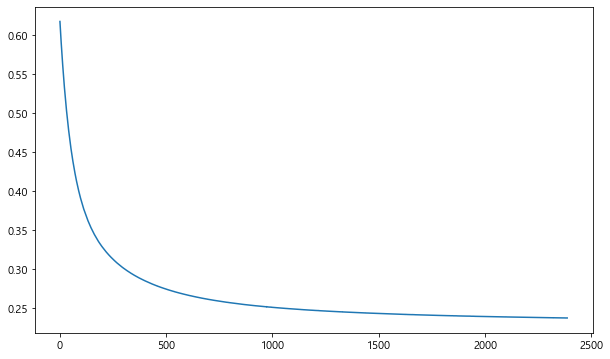

In [417]:
plt.plot(h1.history['loss'])

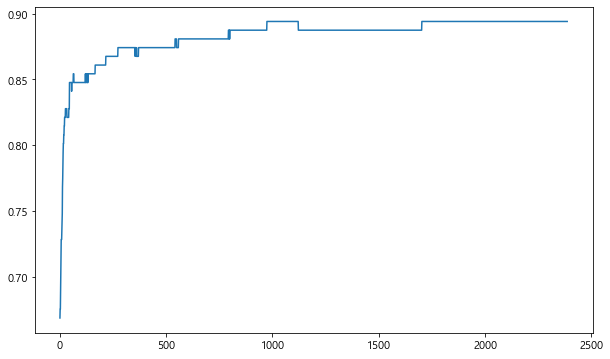

In [418]:
plt.plot(h1.history['accuracy'])

In [419]:
confusion_matrix(y_train, (h1.model.predict(x_train)>0.5)+0)

array([[59,  9],
       [ 7, 76]], dtype=int64)

In [420]:
f1_score(y_train, (h1.model.predict(x_train)>0.5)+0)

0.9047619047619048

In [421]:
accuracy_score(y_train, (h1.model.predict(x_train)>0.5)+0)

0.8940397350993378

In [422]:
r2_score(y_train, (h1.model.predict(x_train)>0.5)+0)

0.5719347980155918

#### 검증 데이터

- monitor -> loss

In [423]:
xv_train, x_valid, yv_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [424]:
dense = Dense(units=1, input_dim=23, activation='sigmoid')
model=Sequential([dense])
model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
earlystop = EarlyStopping(monitor='loss', patience=200, min_delta=0.001)
h2=model.fit(xv_train, yv_train, epochs=10000, callbacks=[earlystop], validation_data=(x_valid, y_valid))

Epoch 1/10000
4/4 [==============================] - 0s 18ms/step - loss: 0.6145 - accuracy: 0.7500 - val_loss: 0.6631 - val_accuracy: 0.5806
Epoch 2/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.6106 - accuracy: 0.7500 - val_loss: 0.6600 - val_accuracy: 0.5806
Epoch 3/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.6065 - accuracy: 0.7500 - val_loss: 0.6571 - val_accuracy: 0.5806
Epoch 4/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.6027 - accuracy: 0.7500 - val_loss: 0.6542 - val_accuracy: 0.5806
Epoch 5/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.5987 - accuracy: 0.7500 - val_loss: 0.6515 - val_accuracy: 0.5806
Epoch 6/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.5951 - accuracy: 0.7500 - val_loss: 0.6487 - val_accuracy: 0.5806
Epoch 7/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.5913 - accuracy: 0.7500 - val_loss: 0.6460 - val_accuracy: 0.5806
Epoch 8/1000

Epoch 59/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.4571 - accuracy: 0.8167 - val_loss: 0.5487 - val_accuracy: 0.6452
Epoch 60/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.4554 - accuracy: 0.8167 - val_loss: 0.5475 - val_accuracy: 0.6452
Epoch 61/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.4535 - accuracy: 0.8167 - val_loss: 0.5463 - val_accuracy: 0.6452
Epoch 62/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.4518 - accuracy: 0.8167 - val_loss: 0.5451 - val_accuracy: 0.6452
Epoch 63/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.4502 - accuracy: 0.8167 - val_loss: 0.5439 - val_accuracy: 0.6452
Epoch 64/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.4484 - accuracy: 0.8167 - val_loss: 0.5427 - val_accuracy: 0.6452
Epoch 65/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.4467 - accuracy: 0.8167 - val_loss: 0.5415 - val_accuracy: 0.6452
Epoch 

4/4 [==============================] - 0s 2ms/step - loss: 0.3836 - accuracy: 0.8333 - val_loss: 0.4975 - val_accuracy: 0.7742
Epoch 117/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.3827 - accuracy: 0.8333 - val_loss: 0.4969 - val_accuracy: 0.7742
Epoch 118/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.3818 - accuracy: 0.8333 - val_loss: 0.4962 - val_accuracy: 0.7742
Epoch 119/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.3809 - accuracy: 0.8333 - val_loss: 0.4955 - val_accuracy: 0.7742
Epoch 120/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.3799 - accuracy: 0.8333 - val_loss: 0.4949 - val_accuracy: 0.7742
Epoch 121/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.3791 - accuracy: 0.8333 - val_loss: 0.4943 - val_accuracy: 0.7742
Epoch 122/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.3782 - accuracy: 0.8250 - val_loss: 0.4937 - val_accuracy: 0.7742
Epoch 123/10000

4/4 [==============================] - 0s 2ms/step - loss: 0.3429 - accuracy: 0.8500 - val_loss: 0.4693 - val_accuracy: 0.7742
Epoch 174/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.3424 - accuracy: 0.8500 - val_loss: 0.4689 - val_accuracy: 0.7742
Epoch 175/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.3418 - accuracy: 0.8500 - val_loss: 0.4685 - val_accuracy: 0.7742
Epoch 176/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.3413 - accuracy: 0.8500 - val_loss: 0.4681 - val_accuracy: 0.7742
Epoch 177/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.3408 - accuracy: 0.8500 - val_loss: 0.4678 - val_accuracy: 0.7742
Epoch 178/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.3402 - accuracy: 0.8500 - val_loss: 0.4674 - val_accuracy: 0.7742
Epoch 179/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.3397 - accuracy: 0.8500 - val_loss: 0.4671 - val_accuracy: 0.7742
Epoch 180/10000

4/4 [==============================] - 0s 2ms/step - loss: 0.3174 - accuracy: 0.8667 - val_loss: 0.4517 - val_accuracy: 0.8065
Epoch 231/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.3170 - accuracy: 0.8667 - val_loss: 0.4514 - val_accuracy: 0.8065
Epoch 232/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.3167 - accuracy: 0.8667 - val_loss: 0.4512 - val_accuracy: 0.8065
Epoch 233/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.3163 - accuracy: 0.8667 - val_loss: 0.4509 - val_accuracy: 0.8065
Epoch 234/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.3160 - accuracy: 0.8667 - val_loss: 0.4507 - val_accuracy: 0.8065
Epoch 235/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.3156 - accuracy: 0.8750 - val_loss: 0.4504 - val_accuracy: 0.8065
Epoch 236/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.3153 - accuracy: 0.8750 - val_loss: 0.4502 - val_accuracy: 0.8065
Epoch 237/10000

4/4 [==============================] - 0s 2ms/step - loss: 0.2999 - accuracy: 0.8917 - val_loss: 0.4396 - val_accuracy: 0.8065
Epoch 288/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2996 - accuracy: 0.8917 - val_loss: 0.4394 - val_accuracy: 0.8065
Epoch 289/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2994 - accuracy: 0.8917 - val_loss: 0.4391 - val_accuracy: 0.8065
Epoch 290/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2991 - accuracy: 0.8917 - val_loss: 0.4390 - val_accuracy: 0.8065
Epoch 291/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2988 - accuracy: 0.8917 - val_loss: 0.4389 - val_accuracy: 0.8065
Epoch 292/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2986 - accuracy: 0.8917 - val_loss: 0.4388 - val_accuracy: 0.8065
Epoch 293/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2983 - accuracy: 0.8917 - val_loss: 0.4386 - val_accuracy: 0.8065
Epoch 294/10000

4/4 [==============================] - 0s 2ms/step - loss: 0.2869 - accuracy: 0.8917 - val_loss: 0.4305 - val_accuracy: 0.8065
Epoch 345/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2868 - accuracy: 0.8917 - val_loss: 0.4303 - val_accuracy: 0.8065
Epoch 346/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2865 - accuracy: 0.8917 - val_loss: 0.4301 - val_accuracy: 0.8065
Epoch 347/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2864 - accuracy: 0.8917 - val_loss: 0.4300 - val_accuracy: 0.8065
Epoch 348/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2861 - accuracy: 0.8917 - val_loss: 0.4299 - val_accuracy: 0.8065
Epoch 349/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2859 - accuracy: 0.8917 - val_loss: 0.4299 - val_accuracy: 0.8065
Epoch 350/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2858 - accuracy: 0.8917 - val_loss: 0.4297 - val_accuracy: 0.8065
Epoch 351/10000

4/4 [==============================] - 0s 2ms/step - loss: 0.2771 - accuracy: 0.9000 - val_loss: 0.4241 - val_accuracy: 0.8065
Epoch 402/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2769 - accuracy: 0.9000 - val_loss: 0.4240 - val_accuracy: 0.8065
Epoch 403/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2768 - accuracy: 0.9000 - val_loss: 0.4240 - val_accuracy: 0.8065
Epoch 404/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2767 - accuracy: 0.9000 - val_loss: 0.4239 - val_accuracy: 0.8065
Epoch 405/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2765 - accuracy: 0.9000 - val_loss: 0.4238 - val_accuracy: 0.8065
Epoch 406/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2764 - accuracy: 0.9000 - val_loss: 0.4237 - val_accuracy: 0.8065
Epoch 407/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2762 - accuracy: 0.9000 - val_loss: 0.4236 - val_accuracy: 0.8065
Epoch 408/10000

4/4 [==============================] - 0s 2ms/step - loss: 0.2693 - accuracy: 0.9000 - val_loss: 0.4191 - val_accuracy: 0.8065
Epoch 459/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2692 - accuracy: 0.9000 - val_loss: 0.4188 - val_accuracy: 0.8065
Epoch 460/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2691 - accuracy: 0.9000 - val_loss: 0.4187 - val_accuracy: 0.8065
Epoch 461/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2689 - accuracy: 0.9000 - val_loss: 0.4186 - val_accuracy: 0.8065
Epoch 462/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2688 - accuracy: 0.9000 - val_loss: 0.4184 - val_accuracy: 0.8065
Epoch 463/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2687 - accuracy: 0.9000 - val_loss: 0.4184 - val_accuracy: 0.8065
Epoch 464/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2686 - accuracy: 0.9000 - val_loss: 0.4182 - val_accuracy: 0.8065
Epoch 465/10000

4/4 [==============================] - 0s 2ms/step - loss: 0.2630 - accuracy: 0.8917 - val_loss: 0.4151 - val_accuracy: 0.8065
Epoch 516/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2629 - accuracy: 0.8917 - val_loss: 0.4151 - val_accuracy: 0.8065
Epoch 517/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2628 - accuracy: 0.8917 - val_loss: 0.4150 - val_accuracy: 0.8065
Epoch 518/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2627 - accuracy: 0.8917 - val_loss: 0.4150 - val_accuracy: 0.8065
Epoch 519/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2626 - accuracy: 0.8917 - val_loss: 0.4149 - val_accuracy: 0.8065
Epoch 520/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2625 - accuracy: 0.8917 - val_loss: 0.4148 - val_accuracy: 0.8065
Epoch 521/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2624 - accuracy: 0.8917 - val_loss: 0.4147 - val_accuracy: 0.8065
Epoch 522/10000

4/4 [==============================] - 0s 2ms/step - loss: 0.2578 - accuracy: 0.8917 - val_loss: 0.4115 - val_accuracy: 0.8065
Epoch 573/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2577 - accuracy: 0.8917 - val_loss: 0.4115 - val_accuracy: 0.8065
Epoch 574/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2576 - accuracy: 0.8917 - val_loss: 0.4114 - val_accuracy: 0.8065
Epoch 575/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2575 - accuracy: 0.8917 - val_loss: 0.4113 - val_accuracy: 0.8065
Epoch 576/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2574 - accuracy: 0.8917 - val_loss: 0.4113 - val_accuracy: 0.8065
Epoch 577/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2574 - accuracy: 0.8917 - val_loss: 0.4113 - val_accuracy: 0.8065
Epoch 578/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2573 - accuracy: 0.8917 - val_loss: 0.4112 - val_accuracy: 0.8065
Epoch 579/10000

4/4 [==============================] - 0s 2ms/step - loss: 0.2533 - accuracy: 0.8917 - val_loss: 0.4085 - val_accuracy: 0.8065
Epoch 630/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2533 - accuracy: 0.8917 - val_loss: 0.4083 - val_accuracy: 0.8065
Epoch 631/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2532 - accuracy: 0.8917 - val_loss: 0.4084 - val_accuracy: 0.8065
Epoch 632/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2531 - accuracy: 0.8917 - val_loss: 0.4083 - val_accuracy: 0.8065
Epoch 633/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2531 - accuracy: 0.8917 - val_loss: 0.4083 - val_accuracy: 0.8065
Epoch 634/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2530 - accuracy: 0.8917 - val_loss: 0.4082 - val_accuracy: 0.8065
Epoch 635/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2529 - accuracy: 0.8917 - val_loss: 0.4082 - val_accuracy: 0.8065
Epoch 636/10000

4/4 [==============================] - 0s 2ms/step - loss: 0.2496 - accuracy: 0.8917 - val_loss: 0.4067 - val_accuracy: 0.8065
Epoch 687/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2495 - accuracy: 0.8917 - val_loss: 0.4067 - val_accuracy: 0.8065
Epoch 688/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2495 - accuracy: 0.8917 - val_loss: 0.4066 - val_accuracy: 0.8065
Epoch 689/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2494 - accuracy: 0.8917 - val_loss: 0.4065 - val_accuracy: 0.8065
Epoch 690/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2493 - accuracy: 0.8917 - val_loss: 0.4066 - val_accuracy: 0.8065
Epoch 691/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2493 - accuracy: 0.8917 - val_loss: 0.4066 - val_accuracy: 0.8065
Epoch 692/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2492 - accuracy: 0.8917 - val_loss: 0.4067 - val_accuracy: 0.8065
Epoch 693/10000

4/4 [==============================] - 0s 2ms/step - loss: 0.2463 - accuracy: 0.8917 - val_loss: 0.4048 - val_accuracy: 0.8065
Epoch 744/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2463 - accuracy: 0.8917 - val_loss: 0.4048 - val_accuracy: 0.8065
Epoch 745/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2462 - accuracy: 0.8917 - val_loss: 0.4047 - val_accuracy: 0.8065
Epoch 746/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2462 - accuracy: 0.8917 - val_loss: 0.4047 - val_accuracy: 0.8065
Epoch 747/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2461 - accuracy: 0.8917 - val_loss: 0.4046 - val_accuracy: 0.8065
Epoch 748/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2461 - accuracy: 0.8917 - val_loss: 0.4048 - val_accuracy: 0.8065
Epoch 749/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2460 - accuracy: 0.8917 - val_loss: 0.4048 - val_accuracy: 0.8065
Epoch 750/10000

4/4 [==============================] - 0s 2ms/step - loss: 0.2435 - accuracy: 0.8917 - val_loss: 0.4038 - val_accuracy: 0.8065
Epoch 801/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2434 - accuracy: 0.8917 - val_loss: 0.4038 - val_accuracy: 0.8065
Epoch 802/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2434 - accuracy: 0.8917 - val_loss: 0.4037 - val_accuracy: 0.8065
Epoch 803/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2433 - accuracy: 0.8917 - val_loss: 0.4036 - val_accuracy: 0.8065
Epoch 804/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2433 - accuracy: 0.8917 - val_loss: 0.4035 - val_accuracy: 0.8065
Epoch 805/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2433 - accuracy: 0.8917 - val_loss: 0.4034 - val_accuracy: 0.8065
Epoch 806/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2432 - accuracy: 0.8917 - val_loss: 0.4034 - val_accuracy: 0.8065
Epoch 807/10000

4/4 [==============================] - 0s 3ms/step - loss: 0.2410 - accuracy: 0.8917 - val_loss: 0.4032 - val_accuracy: 0.8065
Epoch 858/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2409 - accuracy: 0.8917 - val_loss: 0.4031 - val_accuracy: 0.8065
Epoch 859/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2409 - accuracy: 0.8917 - val_loss: 0.4031 - val_accuracy: 0.8065
Epoch 860/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2408 - accuracy: 0.8917 - val_loss: 0.4031 - val_accuracy: 0.8065
Epoch 861/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2409 - accuracy: 0.8917 - val_loss: 0.4029 - val_accuracy: 0.8065
Epoch 862/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2408 - accuracy: 0.8917 - val_loss: 0.4029 - val_accuracy: 0.8065
Epoch 863/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2407 - accuracy: 0.8917 - val_loss: 0.4030 - val_accuracy: 0.8065
Epoch 864/10000

4/4 [==============================] - 0s 3ms/step - loss: 0.2387 - accuracy: 0.8917 - val_loss: 0.4022 - val_accuracy: 0.8065
Epoch 915/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2387 - accuracy: 0.8917 - val_loss: 0.4021 - val_accuracy: 0.8065
Epoch 916/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2387 - accuracy: 0.8917 - val_loss: 0.4022 - val_accuracy: 0.8065
Epoch 917/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2386 - accuracy: 0.8917 - val_loss: 0.4021 - val_accuracy: 0.8065
Epoch 918/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2386 - accuracy: 0.8917 - val_loss: 0.4020 - val_accuracy: 0.8065
Epoch 919/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2386 - accuracy: 0.8917 - val_loss: 0.4020 - val_accuracy: 0.8065
Epoch 920/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2385 - accuracy: 0.8917 - val_loss: 0.4021 - val_accuracy: 0.8065
Epoch 921/10000

4/4 [==============================] - 0s 2ms/step - loss: 0.2368 - accuracy: 0.9000 - val_loss: 0.4022 - val_accuracy: 0.7742
Epoch 972/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2368 - accuracy: 0.9000 - val_loss: 0.4022 - val_accuracy: 0.7742
Epoch 973/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2367 - accuracy: 0.9000 - val_loss: 0.4020 - val_accuracy: 0.7742
Epoch 974/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2367 - accuracy: 0.9000 - val_loss: 0.4019 - val_accuracy: 0.7742
Epoch 975/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2367 - accuracy: 0.9000 - val_loss: 0.4017 - val_accuracy: 0.7742
Epoch 976/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2366 - accuracy: 0.9000 - val_loss: 0.4018 - val_accuracy: 0.7742
Epoch 977/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2366 - accuracy: 0.9000 - val_loss: 0.4018 - val_accuracy: 0.7742
Epoch 978/10000

4/4 [==============================] - 0s 3ms/step - loss: 0.2350 - accuracy: 0.9000 - val_loss: 0.4018 - val_accuracy: 0.7742
Epoch 1029/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2350 - accuracy: 0.9000 - val_loss: 0.4018 - val_accuracy: 0.7742
Epoch 1030/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2350 - accuracy: 0.9000 - val_loss: 0.4017 - val_accuracy: 0.7742
Epoch 1031/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2350 - accuracy: 0.9000 - val_loss: 0.4019 - val_accuracy: 0.7742
Epoch 1032/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2349 - accuracy: 0.9000 - val_loss: 0.4018 - val_accuracy: 0.7742
Epoch 1033/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2349 - accuracy: 0.9000 - val_loss: 0.4018 - val_accuracy: 0.7742
Epoch 1034/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2348 - accuracy: 0.9000 - val_loss: 0.4018 - val_accuracy: 0.7742
Epoch 103

4/4 [==============================] - 0s 2ms/step - loss: 0.2334 - accuracy: 0.9000 - val_loss: 0.4018 - val_accuracy: 0.7742
Epoch 1086/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2334 - accuracy: 0.9000 - val_loss: 0.4019 - val_accuracy: 0.7742
Epoch 1087/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2334 - accuracy: 0.9000 - val_loss: 0.4019 - val_accuracy: 0.7742
Epoch 1088/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2334 - accuracy: 0.9000 - val_loss: 0.4017 - val_accuracy: 0.7742
Epoch 1089/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2333 - accuracy: 0.9000 - val_loss: 0.4018 - val_accuracy: 0.7742
Epoch 1090/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2333 - accuracy: 0.9000 - val_loss: 0.4019 - val_accuracy: 0.7742
Epoch 1091/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2333 - accuracy: 0.9000 - val_loss: 0.4019 - val_accuracy: 0.7742
Epoch 109

4/4 [==============================] - 0s 3ms/step - loss: 0.2320 - accuracy: 0.9000 - val_loss: 0.4020 - val_accuracy: 0.7742
Epoch 1143/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2320 - accuracy: 0.9000 - val_loss: 0.4021 - val_accuracy: 0.7742
Epoch 1144/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2319 - accuracy: 0.9000 - val_loss: 0.4020 - val_accuracy: 0.7742
Epoch 1145/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2319 - accuracy: 0.9000 - val_loss: 0.4019 - val_accuracy: 0.7742
Epoch 1146/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2319 - accuracy: 0.9000 - val_loss: 0.4019 - val_accuracy: 0.7742
Epoch 1147/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2319 - accuracy: 0.9000 - val_loss: 0.4019 - val_accuracy: 0.7742
Epoch 1148/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2318 - accuracy: 0.9000 - val_loss: 0.4020 - val_accuracy: 0.7742
Epoch 114

4/4 [==============================] - 0s 2ms/step - loss: 0.2307 - accuracy: 0.9000 - val_loss: 0.4017 - val_accuracy: 0.7742
Epoch 1200/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2307 - accuracy: 0.9000 - val_loss: 0.4016 - val_accuracy: 0.7742
Epoch 1201/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2306 - accuracy: 0.9000 - val_loss: 0.4014 - val_accuracy: 0.7742
Epoch 1202/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2306 - accuracy: 0.9000 - val_loss: 0.4014 - val_accuracy: 0.7742
Epoch 1203/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2306 - accuracy: 0.9000 - val_loss: 0.4013 - val_accuracy: 0.7742
Epoch 1204/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2306 - accuracy: 0.9000 - val_loss: 0.4014 - val_accuracy: 0.7742
Epoch 1205/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2306 - accuracy: 0.9000 - val_loss: 0.4013 - val_accuracy: 0.7742
Epoch 120

4/4 [==============================] - 0s 2ms/step - loss: 0.2295 - accuracy: 0.9000 - val_loss: 0.4014 - val_accuracy: 0.7742
Epoch 1257/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2294 - accuracy: 0.9000 - val_loss: 0.4014 - val_accuracy: 0.7742
Epoch 1258/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2295 - accuracy: 0.9000 - val_loss: 0.4013 - val_accuracy: 0.7742
Epoch 1259/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2294 - accuracy: 0.9000 - val_loss: 0.4015 - val_accuracy: 0.7742
Epoch 1260/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2295 - accuracy: 0.9000 - val_loss: 0.4016 - val_accuracy: 0.7742
Epoch 1261/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2294 - accuracy: 0.9000 - val_loss: 0.4015 - val_accuracy: 0.7742
Epoch 1262/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2294 - accuracy: 0.9000 - val_loss: 0.4014 - val_accuracy: 0.7742
Epoch 126

4/4 [==============================] - 0s 2ms/step - loss: 0.2284 - accuracy: 0.9083 - val_loss: 0.4016 - val_accuracy: 0.7742
Epoch 1314/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2284 - accuracy: 0.9083 - val_loss: 0.4015 - val_accuracy: 0.7742
Epoch 1315/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2284 - accuracy: 0.9083 - val_loss: 0.4015 - val_accuracy: 0.7742
Epoch 1316/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2283 - accuracy: 0.9083 - val_loss: 0.4017 - val_accuracy: 0.7742
Epoch 1317/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2283 - accuracy: 0.9083 - val_loss: 0.4016 - val_accuracy: 0.7742
Epoch 1318/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2283 - accuracy: 0.9083 - val_loss: 0.4017 - val_accuracy: 0.7742
Epoch 1319/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2282 - accuracy: 0.9083 - val_loss: 0.4018 - val_accuracy: 0.7742
Epoch 132

4/4 [==============================] - 0s 2ms/step - loss: 0.2273 - accuracy: 0.9083 - val_loss: 0.4029 - val_accuracy: 0.7742
Epoch 1371/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2273 - accuracy: 0.9083 - val_loss: 0.4028 - val_accuracy: 0.7742
Epoch 1372/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2273 - accuracy: 0.9083 - val_loss: 0.4028 - val_accuracy: 0.7742
Epoch 1373/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2273 - accuracy: 0.9083 - val_loss: 0.4029 - val_accuracy: 0.7742
Epoch 1374/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2273 - accuracy: 0.9083 - val_loss: 0.4028 - val_accuracy: 0.7742
Epoch 1375/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2273 - accuracy: 0.9083 - val_loss: 0.4028 - val_accuracy: 0.7742
Epoch 1376/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2272 - accuracy: 0.9083 - val_loss: 0.4027 - val_accuracy: 0.7742
Epoch 137

4/4 [==============================] - 0s 3ms/step - loss: 0.2264 - accuracy: 0.9083 - val_loss: 0.4026 - val_accuracy: 0.7742
Epoch 1428/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2264 - accuracy: 0.9083 - val_loss: 0.4027 - val_accuracy: 0.7742
Epoch 1429/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2263 - accuracy: 0.9083 - val_loss: 0.4027 - val_accuracy: 0.7742
Epoch 1430/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2264 - accuracy: 0.9083 - val_loss: 0.4028 - val_accuracy: 0.7742
Epoch 1431/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2263 - accuracy: 0.9083 - val_loss: 0.4029 - val_accuracy: 0.7742
Epoch 1432/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2263 - accuracy: 0.9083 - val_loss: 0.4027 - val_accuracy: 0.7742
Epoch 1433/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2263 - accuracy: 0.9083 - val_loss: 0.4026 - val_accuracy: 0.7742
Epoch 143

4/4 [==============================] - 0s 2ms/step - loss: 0.2255 - accuracy: 0.9083 - val_loss: 0.4030 - val_accuracy: 0.7742
Epoch 1485/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2255 - accuracy: 0.9083 - val_loss: 0.4031 - val_accuracy: 0.7742
Epoch 1486/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2255 - accuracy: 0.9083 - val_loss: 0.4030 - val_accuracy: 0.7742
Epoch 1487/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2254 - accuracy: 0.9083 - val_loss: 0.4031 - val_accuracy: 0.7742
Epoch 1488/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2254 - accuracy: 0.9083 - val_loss: 0.4031 - val_accuracy: 0.7742
Epoch 1489/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2255 - accuracy: 0.9083 - val_loss: 0.4033 - val_accuracy: 0.7742
Epoch 1490/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2254 - accuracy: 0.9083 - val_loss: 0.4032 - val_accuracy: 0.7742
Epoch 149

4/4 [==============================] - 0s 2ms/step - loss: 0.2247 - accuracy: 0.9083 - val_loss: 0.4038 - val_accuracy: 0.7742
Epoch 1542/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2247 - accuracy: 0.9083 - val_loss: 0.4037 - val_accuracy: 0.7742
Epoch 1543/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2246 - accuracy: 0.9083 - val_loss: 0.4039 - val_accuracy: 0.7742
Epoch 1544/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2246 - accuracy: 0.9083 - val_loss: 0.4039 - val_accuracy: 0.7742
Epoch 1545/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2246 - accuracy: 0.9083 - val_loss: 0.4039 - val_accuracy: 0.7742
Epoch 1546/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2246 - accuracy: 0.9083 - val_loss: 0.4038 - val_accuracy: 0.7742
Epoch 1547/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2246 - accuracy: 0.9083 - val_loss: 0.4039 - val_accuracy: 0.7742
Epoch 154

4/4 [==============================] - 0s 3ms/step - loss: 0.2239 - accuracy: 0.9083 - val_loss: 0.4043 - val_accuracy: 0.7742
Epoch 1599/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2238 - accuracy: 0.9083 - val_loss: 0.4043 - val_accuracy: 0.7742
Epoch 1600/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2238 - accuracy: 0.9083 - val_loss: 0.4043 - val_accuracy: 0.7742
Epoch 1601/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2238 - accuracy: 0.9083 - val_loss: 0.4044 - val_accuracy: 0.7742
Epoch 1602/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2238 - accuracy: 0.9083 - val_loss: 0.4044 - val_accuracy: 0.7742
Epoch 1603/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2238 - accuracy: 0.9083 - val_loss: 0.4043 - val_accuracy: 0.7742
Epoch 1604/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2238 - accuracy: 0.9083 - val_loss: 0.4042 - val_accuracy: 0.7742
Epoch 160

4/4 [==============================] - 0s 3ms/step - loss: 0.2232 - accuracy: 0.9083 - val_loss: 0.4049 - val_accuracy: 0.7742
Epoch 1656/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2231 - accuracy: 0.9083 - val_loss: 0.4049 - val_accuracy: 0.7742
Epoch 1657/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2231 - accuracy: 0.9083 - val_loss: 0.4049 - val_accuracy: 0.7742
Epoch 1658/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2231 - accuracy: 0.9083 - val_loss: 0.4048 - val_accuracy: 0.7742
Epoch 1659/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2231 - accuracy: 0.9083 - val_loss: 0.4048 - val_accuracy: 0.7742
Epoch 1660/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2231 - accuracy: 0.9083 - val_loss: 0.4046 - val_accuracy: 0.7742
Epoch 1661/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2231 - accuracy: 0.9083 - val_loss: 0.4046 - val_accuracy: 0.7742
Epoch 166

4/4 [==============================] - 0s 2ms/step - loss: 0.2224 - accuracy: 0.9083 - val_loss: 0.4052 - val_accuracy: 0.7742
Epoch 1713/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2224 - accuracy: 0.9083 - val_loss: 0.4052 - val_accuracy: 0.7742
Epoch 1714/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2224 - accuracy: 0.9083 - val_loss: 0.4052 - val_accuracy: 0.7742
Epoch 1715/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2224 - accuracy: 0.9083 - val_loss: 0.4052 - val_accuracy: 0.7742
Epoch 1716/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2224 - accuracy: 0.9083 - val_loss: 0.4052 - val_accuracy: 0.7742
Epoch 1717/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2224 - accuracy: 0.9083 - val_loss: 0.4052 - val_accuracy: 0.7742
Epoch 1718/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2224 - accuracy: 0.9083 - val_loss: 0.4053 - val_accuracy: 0.7742
Epoch 171

4/4 [==============================] - 0s 2ms/step - loss: 0.2218 - accuracy: 0.9083 - val_loss: 0.4060 - val_accuracy: 0.7742
Epoch 1770/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2218 - accuracy: 0.9083 - val_loss: 0.4061 - val_accuracy: 0.7742
Epoch 1771/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2218 - accuracy: 0.9083 - val_loss: 0.4061 - val_accuracy: 0.7742
Epoch 1772/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2217 - accuracy: 0.9083 - val_loss: 0.4060 - val_accuracy: 0.7742
Epoch 1773/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2217 - accuracy: 0.9083 - val_loss: 0.4060 - val_accuracy: 0.7742
Epoch 1774/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2219 - accuracy: 0.9083 - val_loss: 0.4056 - val_accuracy: 0.7742
Epoch 1775/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2217 - accuracy: 0.9083 - val_loss: 0.4056 - val_accuracy: 0.7742
Epoch 177

4/4 [==============================] - 0s 3ms/step - loss: 0.2212 - accuracy: 0.9000 - val_loss: 0.4060 - val_accuracy: 0.7742
Epoch 1827/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2212 - accuracy: 0.9000 - val_loss: 0.4062 - val_accuracy: 0.7742
Epoch 1828/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2212 - accuracy: 0.9000 - val_loss: 0.4063 - val_accuracy: 0.7742
Epoch 1829/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2212 - accuracy: 0.9000 - val_loss: 0.4062 - val_accuracy: 0.7742
Epoch 1830/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2211 - accuracy: 0.9000 - val_loss: 0.4062 - val_accuracy: 0.7742
Epoch 1831/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2211 - accuracy: 0.9000 - val_loss: 0.4062 - val_accuracy: 0.7742
Epoch 1832/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2211 - accuracy: 0.9000 - val_loss: 0.4063 - val_accuracy: 0.7742
Epoch 183

4/4 [==============================] - 0s 3ms/step - loss: 0.2206 - accuracy: 0.9000 - val_loss: 0.4062 - val_accuracy: 0.7742
Epoch 1884/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2206 - accuracy: 0.9000 - val_loss: 0.4062 - val_accuracy: 0.7742
Epoch 1885/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2205 - accuracy: 0.9000 - val_loss: 0.4062 - val_accuracy: 0.7742
Epoch 1886/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2206 - accuracy: 0.9000 - val_loss: 0.4061 - val_accuracy: 0.7742
Epoch 1887/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2206 - accuracy: 0.9000 - val_loss: 0.4063 - val_accuracy: 0.7742
Epoch 1888/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2205 - accuracy: 0.9000 - val_loss: 0.4064 - val_accuracy: 0.7742
Epoch 1889/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2205 - accuracy: 0.9000 - val_loss: 0.4064 - val_accuracy: 0.7742
Epoch 189

4/4 [==============================] - 0s 3ms/step - loss: 0.2200 - accuracy: 0.9000 - val_loss: 0.4066 - val_accuracy: 0.7742
Epoch 1941/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2200 - accuracy: 0.9000 - val_loss: 0.4067 - val_accuracy: 0.7742
Epoch 1942/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2200 - accuracy: 0.9000 - val_loss: 0.4069 - val_accuracy: 0.7742
Epoch 1943/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2200 - accuracy: 0.9000 - val_loss: 0.4069 - val_accuracy: 0.7742
Epoch 1944/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2200 - accuracy: 0.9000 - val_loss: 0.4070 - val_accuracy: 0.7742
Epoch 1945/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2200 - accuracy: 0.9000 - val_loss: 0.4072 - val_accuracy: 0.7742
Epoch 1946/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2200 - accuracy: 0.9000 - val_loss: 0.4072 - val_accuracy: 0.7742
Epoch 194

4/4 [==============================] - 0s 3ms/step - loss: 0.2195 - accuracy: 0.9000 - val_loss: 0.4085 - val_accuracy: 0.7742
Epoch 1998/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2194 - accuracy: 0.9000 - val_loss: 0.4085 - val_accuracy: 0.7742
Epoch 1999/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2194 - accuracy: 0.9000 - val_loss: 0.4084 - val_accuracy: 0.7742
Epoch 2000/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2194 - accuracy: 0.9000 - val_loss: 0.4084 - val_accuracy: 0.7742
Epoch 2001/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2194 - accuracy: 0.9000 - val_loss: 0.4084 - val_accuracy: 0.7742
Epoch 2002/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2194 - accuracy: 0.9000 - val_loss: 0.4082 - val_accuracy: 0.7742
Epoch 2003/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2194 - accuracy: 0.9000 - val_loss: 0.4083 - val_accuracy: 0.7742
Epoch 200

4/4 [==============================] - 0s 3ms/step - loss: 0.2189 - accuracy: 0.9000 - val_loss: 0.4086 - val_accuracy: 0.7742
Epoch 2055/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2189 - accuracy: 0.9000 - val_loss: 0.4086 - val_accuracy: 0.7742
Epoch 2056/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2189 - accuracy: 0.9000 - val_loss: 0.4088 - val_accuracy: 0.7742
Epoch 2057/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2189 - accuracy: 0.9000 - val_loss: 0.4089 - val_accuracy: 0.7742
Epoch 2058/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2189 - accuracy: 0.9000 - val_loss: 0.4090 - val_accuracy: 0.7742
Epoch 2059/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2189 - accuracy: 0.9000 - val_loss: 0.4091 - val_accuracy: 0.7742
Epoch 2060/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2189 - accuracy: 0.9000 - val_loss: 0.4091 - val_accuracy: 0.7742
Epoch 206

4/4 [==============================] - 0s 3ms/step - loss: 0.2184 - accuracy: 0.9000 - val_loss: 0.4094 - val_accuracy: 0.7742
Epoch 2112/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2184 - accuracy: 0.9000 - val_loss: 0.4092 - val_accuracy: 0.7742
Epoch 2113/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2184 - accuracy: 0.9000 - val_loss: 0.4092 - val_accuracy: 0.7742
Epoch 2114/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2184 - accuracy: 0.9000 - val_loss: 0.4092 - val_accuracy: 0.7742
Epoch 2115/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2184 - accuracy: 0.9000 - val_loss: 0.4092 - val_accuracy: 0.7742
Epoch 2116/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2184 - accuracy: 0.9000 - val_loss: 0.4092 - val_accuracy: 0.7742
Epoch 2117/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2184 - accuracy: 0.9000 - val_loss: 0.4092 - val_accuracy: 0.7742
Epoch 211

4/4 [==============================] - 0s 3ms/step - loss: 0.2180 - accuracy: 0.9000 - val_loss: 0.4104 - val_accuracy: 0.7742
Epoch 2169/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2180 - accuracy: 0.9000 - val_loss: 0.4104 - val_accuracy: 0.7742
Epoch 2170/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2180 - accuracy: 0.9000 - val_loss: 0.4105 - val_accuracy: 0.7742
Epoch 2171/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2180 - accuracy: 0.9000 - val_loss: 0.4107 - val_accuracy: 0.7742
Epoch 2172/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2180 - accuracy: 0.9000 - val_loss: 0.4106 - val_accuracy: 0.7742
Epoch 2173/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2179 - accuracy: 0.9000 - val_loss: 0.4107 - val_accuracy: 0.7742
Epoch 2174/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2179 - accuracy: 0.9000 - val_loss: 0.4108 - val_accuracy: 0.7742
Epoch 217

4/4 [==============================] - 0s 2ms/step - loss: 0.2176 - accuracy: 0.9000 - val_loss: 0.4109 - val_accuracy: 0.7742
Epoch 2226/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2175 - accuracy: 0.9000 - val_loss: 0.4109 - val_accuracy: 0.7742
Epoch 2227/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2175 - accuracy: 0.9000 - val_loss: 0.4110 - val_accuracy: 0.7742
Epoch 2228/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2175 - accuracy: 0.9000 - val_loss: 0.4110 - val_accuracy: 0.7742
Epoch 2229/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2175 - accuracy: 0.9000 - val_loss: 0.4111 - val_accuracy: 0.7742
Epoch 2230/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2175 - accuracy: 0.9000 - val_loss: 0.4110 - val_accuracy: 0.7742
Epoch 2231/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2175 - accuracy: 0.9000 - val_loss: 0.4111 - val_accuracy: 0.7742
Epoch 223

4/4 [==============================] - 0s 3ms/step - loss: 0.2171 - accuracy: 0.9000 - val_loss: 0.4115 - val_accuracy: 0.7742
Epoch 2283/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2171 - accuracy: 0.9000 - val_loss: 0.4114 - val_accuracy: 0.7742
Epoch 2284/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2170 - accuracy: 0.9000 - val_loss: 0.4115 - val_accuracy: 0.7742
Epoch 2285/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2171 - accuracy: 0.9000 - val_loss: 0.4113 - val_accuracy: 0.7742
Epoch 2286/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2171 - accuracy: 0.9000 - val_loss: 0.4114 - val_accuracy: 0.7742
Epoch 2287/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2170 - accuracy: 0.9000 - val_loss: 0.4113 - val_accuracy: 0.7742
Epoch 2288/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2170 - accuracy: 0.9000 - val_loss: 0.4114 - val_accuracy: 0.7742
Epoch 228

4/4 [==============================] - 0s 3ms/step - loss: 0.2166 - accuracy: 0.9000 - val_loss: 0.4119 - val_accuracy: 0.7742
Epoch 2340/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2167 - accuracy: 0.9000 - val_loss: 0.4119 - val_accuracy: 0.7742
Epoch 2341/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2166 - accuracy: 0.9000 - val_loss: 0.4118 - val_accuracy: 0.7742
Epoch 2342/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2166 - accuracy: 0.9000 - val_loss: 0.4117 - val_accuracy: 0.7742
Epoch 2343/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2166 - accuracy: 0.9000 - val_loss: 0.4116 - val_accuracy: 0.7742
Epoch 2344/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2166 - accuracy: 0.9000 - val_loss: 0.4117 - val_accuracy: 0.7742
Epoch 2345/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2166 - accuracy: 0.9000 - val_loss: 0.4117 - val_accuracy: 0.7742
Epoch 234

4/4 [==============================] - 0s 3ms/step - loss: 0.2162 - accuracy: 0.9000 - val_loss: 0.4123 - val_accuracy: 0.7742
Epoch 2397/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2162 - accuracy: 0.9000 - val_loss: 0.4123 - val_accuracy: 0.7742
Epoch 2398/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2163 - accuracy: 0.9000 - val_loss: 0.4121 - val_accuracy: 0.7742
Epoch 2399/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2162 - accuracy: 0.9000 - val_loss: 0.4121 - val_accuracy: 0.7742
Epoch 2400/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2162 - accuracy: 0.9000 - val_loss: 0.4120 - val_accuracy: 0.7742
Epoch 2401/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2162 - accuracy: 0.9000 - val_loss: 0.4119 - val_accuracy: 0.7742
Epoch 2402/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2162 - accuracy: 0.9000 - val_loss: 0.4119 - val_accuracy: 0.7742
Epoch 240

Epoch 2453/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2158 - accuracy: 0.9000 - val_loss: 0.4124 - val_accuracy: 0.7742
Epoch 2454/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2158 - accuracy: 0.9000 - val_loss: 0.4124 - val_accuracy: 0.7742
Epoch 2455/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2158 - accuracy: 0.9000 - val_loss: 0.4124 - val_accuracy: 0.7742
Epoch 2456/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2158 - accuracy: 0.9000 - val_loss: 0.4125 - val_accuracy: 0.7742
Epoch 2457/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2158 - accuracy: 0.9000 - val_loss: 0.4125 - val_accuracy: 0.7742
Epoch 2458/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2158 - accuracy: 0.9000 - val_loss: 0.4125 - val_accuracy: 0.7742
Epoch 2459/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2158 - accuracy: 0.9000 - val_loss: 0.4124 - val_accuracy:

Epoch 2510/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2155 - accuracy: 0.9000 - val_loss: 0.4130 - val_accuracy: 0.7742
Epoch 2511/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2154 - accuracy: 0.9000 - val_loss: 0.4131 - val_accuracy: 0.7742
Epoch 2512/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2154 - accuracy: 0.9000 - val_loss: 0.4132 - val_accuracy: 0.7742
Epoch 2513/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2155 - accuracy: 0.9000 - val_loss: 0.4134 - val_accuracy: 0.7742
Epoch 2514/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2154 - accuracy: 0.9000 - val_loss: 0.4135 - val_accuracy: 0.7742
Epoch 2515/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2154 - accuracy: 0.9000 - val_loss: 0.4135 - val_accuracy: 0.7742
Epoch 2516/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2154 - accuracy: 0.9000 - val_loss: 0.4133 - val_accuracy:

Epoch 2567/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2151 - accuracy: 0.9000 - val_loss: 0.4150 - val_accuracy: 0.7742
Epoch 2568/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2151 - accuracy: 0.9000 - val_loss: 0.4150 - val_accuracy: 0.7742
Epoch 2569/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2151 - accuracy: 0.9000 - val_loss: 0.4150 - val_accuracy: 0.7742
Epoch 2570/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2151 - accuracy: 0.9000 - val_loss: 0.4148 - val_accuracy: 0.7742
Epoch 2571/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2151 - accuracy: 0.9000 - val_loss: 0.4147 - val_accuracy: 0.7742
Epoch 2572/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2150 - accuracy: 0.9000 - val_loss: 0.4147 - val_accuracy: 0.7742
Epoch 2573/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2150 - accuracy: 0.9000 - val_loss: 0.4147 - val_accuracy:

Epoch 2624/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2147 - accuracy: 0.9000 - val_loss: 0.4150 - val_accuracy: 0.7742
Epoch 2625/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2147 - accuracy: 0.9000 - val_loss: 0.4151 - val_accuracy: 0.7742
Epoch 2626/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2147 - accuracy: 0.9000 - val_loss: 0.4152 - val_accuracy: 0.7742
Epoch 2627/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2147 - accuracy: 0.9000 - val_loss: 0.4152 - val_accuracy: 0.7742
Epoch 2628/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2147 - accuracy: 0.9000 - val_loss: 0.4152 - val_accuracy: 0.7742
Epoch 2629/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2147 - accuracy: 0.9000 - val_loss: 0.4152 - val_accuracy: 0.7742
Epoch 2630/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2147 - accuracy: 0.9000 - val_loss: 0.4151 - val_accuracy:

Epoch 2681/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2143 - accuracy: 0.9000 - val_loss: 0.4152 - val_accuracy: 0.7742
Epoch 2682/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2144 - accuracy: 0.9000 - val_loss: 0.4153 - val_accuracy: 0.7742
Epoch 2683/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2144 - accuracy: 0.9000 - val_loss: 0.4152 - val_accuracy: 0.7742
Epoch 2684/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2143 - accuracy: 0.9000 - val_loss: 0.4154 - val_accuracy: 0.7742
Epoch 2685/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2143 - accuracy: 0.9000 - val_loss: 0.4155 - val_accuracy: 0.7742
Epoch 2686/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2143 - accuracy: 0.9000 - val_loss: 0.4156 - val_accuracy: 0.7742
Epoch 2687/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2143 - accuracy: 0.9000 - val_loss: 0.4157 - val_accuracy:

Epoch 2738/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2140 - accuracy: 0.9000 - val_loss: 0.4159 - val_accuracy: 0.7742
Epoch 2739/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2140 - accuracy: 0.9000 - val_loss: 0.4159 - val_accuracy: 0.7742
Epoch 2740/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2140 - accuracy: 0.9000 - val_loss: 0.4160 - val_accuracy: 0.7742
Epoch 2741/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2140 - accuracy: 0.9000 - val_loss: 0.4162 - val_accuracy: 0.7742
Epoch 2742/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2140 - accuracy: 0.9000 - val_loss: 0.4160 - val_accuracy: 0.7742
Epoch 2743/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2140 - accuracy: 0.9000 - val_loss: 0.4161 - val_accuracy: 0.7742
Epoch 2744/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2140 - accuracy: 0.9000 - val_loss: 0.4162 - val_accuracy:

Epoch 2795/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2137 - accuracy: 0.9000 - val_loss: 0.4166 - val_accuracy: 0.7742
Epoch 2796/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2137 - accuracy: 0.9000 - val_loss: 0.4166 - val_accuracy: 0.7742
Epoch 2797/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2137 - accuracy: 0.9000 - val_loss: 0.4165 - val_accuracy: 0.7742
Epoch 2798/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2137 - accuracy: 0.9000 - val_loss: 0.4167 - val_accuracy: 0.7742
Epoch 2799/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2136 - accuracy: 0.9000 - val_loss: 0.4167 - val_accuracy: 0.7742
Epoch 2800/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2136 - accuracy: 0.9000 - val_loss: 0.4167 - val_accuracy: 0.7742
Epoch 2801/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2136 - accuracy: 0.9000 - val_loss: 0.4165 - val_accuracy:

Epoch 2852/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2134 - accuracy: 0.9000 - val_loss: 0.4170 - val_accuracy: 0.7742
Epoch 2853/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2134 - accuracy: 0.9000 - val_loss: 0.4172 - val_accuracy: 0.7742
Epoch 2854/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2133 - accuracy: 0.9000 - val_loss: 0.4172 - val_accuracy: 0.7742
Epoch 2855/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2133 - accuracy: 0.9000 - val_loss: 0.4170 - val_accuracy: 0.7742
Epoch 2856/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2133 - accuracy: 0.9000 - val_loss: 0.4171 - val_accuracy: 0.7742
Epoch 2857/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2133 - accuracy: 0.9000 - val_loss: 0.4170 - val_accuracy: 0.7742
Epoch 2858/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2133 - accuracy: 0.9000 - val_loss: 0.4170 - val_accuracy:

Epoch 2909/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2130 - accuracy: 0.9000 - val_loss: 0.4170 - val_accuracy: 0.7742
Epoch 2910/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2130 - accuracy: 0.9000 - val_loss: 0.4170 - val_accuracy: 0.7742
Epoch 2911/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2130 - accuracy: 0.9000 - val_loss: 0.4169 - val_accuracy: 0.7742
Epoch 2912/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2130 - accuracy: 0.9000 - val_loss: 0.4170 - val_accuracy: 0.7742
Epoch 2913/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2130 - accuracy: 0.9000 - val_loss: 0.4170 - val_accuracy: 0.7742
Epoch 2914/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2130 - accuracy: 0.9000 - val_loss: 0.4171 - val_accuracy: 0.7742
Epoch 2915/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2130 - accuracy: 0.9000 - val_loss: 0.4174 - val_accuracy:

Epoch 2966/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2127 - accuracy: 0.9000 - val_loss: 0.4179 - val_accuracy: 0.7742
Epoch 2967/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2127 - accuracy: 0.9000 - val_loss: 0.4178 - val_accuracy: 0.7742
Epoch 2968/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2127 - accuracy: 0.9000 - val_loss: 0.4179 - val_accuracy: 0.7742
Epoch 2969/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2127 - accuracy: 0.9000 - val_loss: 0.4180 - val_accuracy: 0.7742
Epoch 2970/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2127 - accuracy: 0.9000 - val_loss: 0.4181 - val_accuracy: 0.7742
Epoch 2971/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2127 - accuracy: 0.9000 - val_loss: 0.4182 - val_accuracy: 0.7742
Epoch 2972/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2127 - accuracy: 0.9000 - val_loss: 0.4182 - val_accuracy:

Epoch 3023/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2124 - accuracy: 0.9000 - val_loss: 0.4180 - val_accuracy: 0.7742
Epoch 3024/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2124 - accuracy: 0.9000 - val_loss: 0.4183 - val_accuracy: 0.7742
Epoch 3025/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2124 - accuracy: 0.9000 - val_loss: 0.4182 - val_accuracy: 0.7742
Epoch 3026/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2124 - accuracy: 0.9000 - val_loss: 0.4183 - val_accuracy: 0.7742
Epoch 3027/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2124 - accuracy: 0.9000 - val_loss: 0.4184 - val_accuracy: 0.7742
Epoch 3028/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2124 - accuracy: 0.9000 - val_loss: 0.4183 - val_accuracy: 0.7742
Epoch 3029/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2124 - accuracy: 0.9000 - val_loss: 0.4183 - val_accuracy:

Epoch 3080/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2122 - accuracy: 0.9083 - val_loss: 0.4193 - val_accuracy: 0.7742
Epoch 3081/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2121 - accuracy: 0.9000 - val_loss: 0.4192 - val_accuracy: 0.7742
Epoch 3082/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2121 - accuracy: 0.9000 - val_loss: 0.4193 - val_accuracy: 0.7742
Epoch 3083/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2121 - accuracy: 0.9000 - val_loss: 0.4192 - val_accuracy: 0.7742
Epoch 3084/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2121 - accuracy: 0.9000 - val_loss: 0.4191 - val_accuracy: 0.7742
Epoch 3085/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2121 - accuracy: 0.9000 - val_loss: 0.4192 - val_accuracy: 0.7742
Epoch 3086/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2121 - accuracy: 0.9000 - val_loss: 0.4192 - val_accuracy:

Epoch 3137/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2118 - accuracy: 0.9000 - val_loss: 0.4205 - val_accuracy: 0.7742
Epoch 3138/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2118 - accuracy: 0.9000 - val_loss: 0.4206 - val_accuracy: 0.7742
Epoch 3139/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2119 - accuracy: 0.9000 - val_loss: 0.4205 - val_accuracy: 0.7742
Epoch 3140/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2118 - accuracy: 0.9000 - val_loss: 0.4207 - val_accuracy: 0.7742
Epoch 3141/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2118 - accuracy: 0.9000 - val_loss: 0.4207 - val_accuracy: 0.7742
Epoch 3142/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2118 - accuracy: 0.9000 - val_loss: 0.4210 - val_accuracy: 0.7742
Epoch 3143/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2118 - accuracy: 0.9083 - val_loss: 0.4211 - val_accuracy:

Epoch 3194/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2116 - accuracy: 0.9083 - val_loss: 0.4221 - val_accuracy: 0.7742
Epoch 3195/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2116 - accuracy: 0.9083 - val_loss: 0.4221 - val_accuracy: 0.7742
Epoch 3196/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2115 - accuracy: 0.9083 - val_loss: 0.4222 - val_accuracy: 0.7742
Epoch 3197/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2116 - accuracy: 0.9083 - val_loss: 0.4223 - val_accuracy: 0.7742
Epoch 3198/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2115 - accuracy: 0.9083 - val_loss: 0.4224 - val_accuracy: 0.7742
Epoch 3199/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2115 - accuracy: 0.9083 - val_loss: 0.4223 - val_accuracy: 0.7742
Epoch 3200/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2115 - accuracy: 0.9083 - val_loss: 0.4224 - val_accuracy:

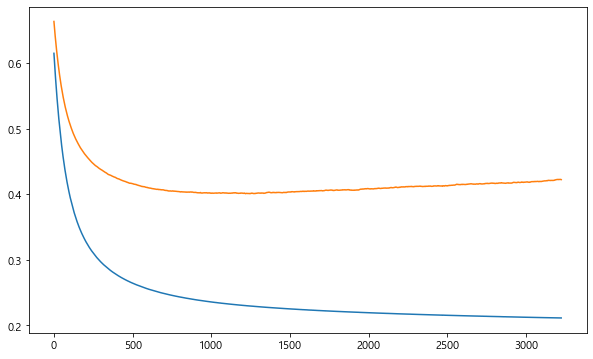

In [425]:
plt.plot(h2.history['loss'])
plt.plot(h2.history['val_loss'])

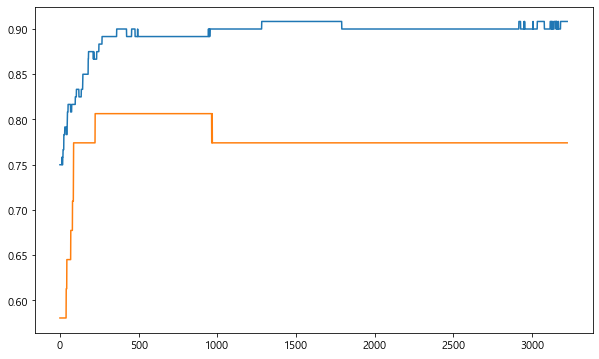

In [426]:
plt.plot(h2.history['accuracy'])
plt.plot(h2.history['val_accuracy'])

In [427]:
confusion_matrix(yv_train, (h2.model.predict(xv_train)>0.5)+0)

array([[47,  7],
       [ 4, 62]], dtype=int64)

In [428]:
f1_score(yv_train, (h2.model.predict(xv_train)>0.5)+0)

0.9185185185185185

In [429]:
accuracy_score(yv_train, (h2.model.predict(xv_train)>0.5)+0)

0.9083333333333333

In [430]:
r2_score(yv_train, (h2.model.predict(xv_train)>0.5)+0)

0.6296296296296298

- monitor -> val_loss

In [431]:
dense = Dense(units=1, input_dim=23, activation='sigmoid')
model=Sequential([dense])
model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
earlystop = EarlyStopping(monitor='val_loss', patience=200, min_delta=0.001)
h3=model.fit(xv_train, yv_train, epochs=10000, callbacks=[earlystop], validation_data=(x_valid, y_valid))

Epoch 1/10000
4/4 [==============================] - 0s 23ms/step - loss: 0.8061 - accuracy: 0.4750 - val_loss: 0.7785 - val_accuracy: 0.4516
Epoch 2/10000
4/4 [==============================] - 0s 1ms/step - loss: 0.7973 - accuracy: 0.4833 - val_loss: 0.7715 - val_accuracy: 0.4839
Epoch 3/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.7893 - accuracy: 0.4833 - val_loss: 0.7646 - val_accuracy: 0.5161
Epoch 4/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.7819 - accuracy: 0.4917 - val_loss: 0.7577 - val_accuracy: 0.5161
Epoch 5/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.7739 - accuracy: 0.4917 - val_loss: 0.7511 - val_accuracy: 0.5161
Epoch 6/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.7662 - accuracy: 0.5000 - val_loss: 0.7447 - val_accuracy: 0.5484
Epoch 7/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.7592 - accuracy: 0.5000 - val_loss: 0.7384 - val_accuracy: 0.5161
Epoch 8/1000

Epoch 59/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.5361 - accuracy: 0.7667 - val_loss: 0.5624 - val_accuracy: 0.7742
Epoch 60/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.5334 - accuracy: 0.7750 - val_loss: 0.5607 - val_accuracy: 0.7742
Epoch 61/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.5311 - accuracy: 0.7750 - val_loss: 0.5589 - val_accuracy: 0.7742
Epoch 62/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.5286 - accuracy: 0.7833 - val_loss: 0.5573 - val_accuracy: 0.7742
Epoch 63/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.5262 - accuracy: 0.7833 - val_loss: 0.5556 - val_accuracy: 0.7742
Epoch 64/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.5239 - accuracy: 0.7917 - val_loss: 0.5540 - val_accuracy: 0.7742
Epoch 65/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.5215 - accuracy: 0.7917 - val_loss: 0.5525 - val_accuracy: 0.7742
Epoch 

4/4 [==============================] - 0s 2ms/step - loss: 0.4342 - accuracy: 0.8250 - val_loss: 0.4983 - val_accuracy: 0.8065
Epoch 117/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.4330 - accuracy: 0.8250 - val_loss: 0.4976 - val_accuracy: 0.8065
Epoch 118/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.4317 - accuracy: 0.8250 - val_loss: 0.4969 - val_accuracy: 0.8065
Epoch 119/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.4304 - accuracy: 0.8250 - val_loss: 0.4963 - val_accuracy: 0.8065
Epoch 120/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.4292 - accuracy: 0.8250 - val_loss: 0.4956 - val_accuracy: 0.8065
Epoch 121/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.4280 - accuracy: 0.8250 - val_loss: 0.4949 - val_accuracy: 0.8065
Epoch 122/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.4268 - accuracy: 0.8250 - val_loss: 0.4943 - val_accuracy: 0.8065
Epoch 123/10000

4/4 [==============================] - 0s 3ms/step - loss: 0.3781 - accuracy: 0.8417 - val_loss: 0.4675 - val_accuracy: 0.7742
Epoch 174/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.3773 - accuracy: 0.8417 - val_loss: 0.4671 - val_accuracy: 0.7742
Epoch 175/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.3765 - accuracy: 0.8417 - val_loss: 0.4668 - val_accuracy: 0.7742
Epoch 176/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.3758 - accuracy: 0.8417 - val_loss: 0.4664 - val_accuracy: 0.7742
Epoch 177/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.3750 - accuracy: 0.8417 - val_loss: 0.4660 - val_accuracy: 0.7742
Epoch 178/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.3743 - accuracy: 0.8417 - val_loss: 0.4657 - val_accuracy: 0.7742
Epoch 179/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.3736 - accuracy: 0.8417 - val_loss: 0.4653 - val_accuracy: 0.7742
Epoch 180/10000

4/4 [==============================] - 0s 2ms/step - loss: 0.3425 - accuracy: 0.8583 - val_loss: 0.4495 - val_accuracy: 0.7742
Epoch 231/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.3420 - accuracy: 0.8583 - val_loss: 0.4493 - val_accuracy: 0.7742
Epoch 232/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.3415 - accuracy: 0.8583 - val_loss: 0.4491 - val_accuracy: 0.7742
Epoch 233/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.3410 - accuracy: 0.8583 - val_loss: 0.4488 - val_accuracy: 0.7742
Epoch 234/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.3405 - accuracy: 0.8583 - val_loss: 0.4485 - val_accuracy: 0.7742
Epoch 235/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.3400 - accuracy: 0.8583 - val_loss: 0.4483 - val_accuracy: 0.7742
Epoch 236/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.3396 - accuracy: 0.8583 - val_loss: 0.4482 - val_accuracy: 0.7742
Epoch 237/10000

4/4 [==============================] - 0s 2ms/step - loss: 0.3180 - accuracy: 0.8583 - val_loss: 0.4381 - val_accuracy: 0.7742
Epoch 288/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.3176 - accuracy: 0.8583 - val_loss: 0.4379 - val_accuracy: 0.7742
Epoch 289/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.3173 - accuracy: 0.8583 - val_loss: 0.4377 - val_accuracy: 0.7742
Epoch 290/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.3169 - accuracy: 0.8583 - val_loss: 0.4376 - val_accuracy: 0.7742
Epoch 291/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.3165 - accuracy: 0.8583 - val_loss: 0.4374 - val_accuracy: 0.7419
Epoch 292/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.3162 - accuracy: 0.8583 - val_loss: 0.4372 - val_accuracy: 0.7419
Epoch 293/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.3158 - accuracy: 0.8583 - val_loss: 0.4370 - val_accuracy: 0.7419
Epoch 294/10000

4/4 [==============================] - 0s 3ms/step - loss: 0.3001 - accuracy: 0.8750 - val_loss: 0.4298 - val_accuracy: 0.7419
Epoch 345/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2998 - accuracy: 0.8833 - val_loss: 0.4297 - val_accuracy: 0.7419
Epoch 346/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2996 - accuracy: 0.8833 - val_loss: 0.4296 - val_accuracy: 0.7419
Epoch 347/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2993 - accuracy: 0.8833 - val_loss: 0.4294 - val_accuracy: 0.7419
Epoch 348/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2990 - accuracy: 0.8833 - val_loss: 0.4292 - val_accuracy: 0.7419
Epoch 349/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2987 - accuracy: 0.8833 - val_loss: 0.4292 - val_accuracy: 0.7419
Epoch 350/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2985 - accuracy: 0.8833 - val_loss: 0.4291 - val_accuracy: 0.7419
Epoch 351/10000

4/4 [==============================] - 0s 2ms/step - loss: 0.2864 - accuracy: 0.8917 - val_loss: 0.4233 - val_accuracy: 0.7742
Epoch 402/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2862 - accuracy: 0.9000 - val_loss: 0.4232 - val_accuracy: 0.7742
Epoch 403/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2860 - accuracy: 0.9000 - val_loss: 0.4231 - val_accuracy: 0.7742
Epoch 404/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2858 - accuracy: 0.9000 - val_loss: 0.4230 - val_accuracy: 0.7742
Epoch 405/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2856 - accuracy: 0.9000 - val_loss: 0.4229 - val_accuracy: 0.7742
Epoch 406/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2854 - accuracy: 0.9000 - val_loss: 0.4228 - val_accuracy: 0.7742
Epoch 407/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2852 - accuracy: 0.9000 - val_loss: 0.4227 - val_accuracy: 0.7742
Epoch 408/10000

4/4 [==============================] - 0s 3ms/step - loss: 0.2758 - accuracy: 0.9000 - val_loss: 0.4186 - val_accuracy: 0.7742
Epoch 459/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2757 - accuracy: 0.9000 - val_loss: 0.4186 - val_accuracy: 0.7742
Epoch 460/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2755 - accuracy: 0.9000 - val_loss: 0.4184 - val_accuracy: 0.7742
Epoch 461/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2754 - accuracy: 0.9000 - val_loss: 0.4183 - val_accuracy: 0.7742
Epoch 462/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2751 - accuracy: 0.9000 - val_loss: 0.4182 - val_accuracy: 0.7742
Epoch 463/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2750 - accuracy: 0.9000 - val_loss: 0.4180 - val_accuracy: 0.7742
Epoch 464/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2748 - accuracy: 0.9000 - val_loss: 0.4180 - val_accuracy: 0.7742
Epoch 465/10000

4/4 [==============================] - 0s 3ms/step - loss: 0.2673 - accuracy: 0.9000 - val_loss: 0.4151 - val_accuracy: 0.7742
Epoch 516/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2672 - accuracy: 0.9000 - val_loss: 0.4151 - val_accuracy: 0.7742
Epoch 517/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2671 - accuracy: 0.9000 - val_loss: 0.4150 - val_accuracy: 0.7742
Epoch 518/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2669 - accuracy: 0.9000 - val_loss: 0.4151 - val_accuracy: 0.7742
Epoch 519/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2668 - accuracy: 0.9000 - val_loss: 0.4150 - val_accuracy: 0.7742
Epoch 520/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2667 - accuracy: 0.9000 - val_loss: 0.4150 - val_accuracy: 0.7742
Epoch 521/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2666 - accuracy: 0.9000 - val_loss: 0.4150 - val_accuracy: 0.7742
Epoch 522/10000

4/4 [==============================] - 0s 2ms/step - loss: 0.2604 - accuracy: 0.8917 - val_loss: 0.4123 - val_accuracy: 0.7742
Epoch 573/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2603 - accuracy: 0.8917 - val_loss: 0.4122 - val_accuracy: 0.7742
Epoch 574/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2602 - accuracy: 0.8917 - val_loss: 0.4121 - val_accuracy: 0.7742
Epoch 575/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2601 - accuracy: 0.8917 - val_loss: 0.4120 - val_accuracy: 0.7742
Epoch 576/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2600 - accuracy: 0.8917 - val_loss: 0.4120 - val_accuracy: 0.7742
Epoch 577/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2599 - accuracy: 0.8917 - val_loss: 0.4118 - val_accuracy: 0.7742
Epoch 578/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2598 - accuracy: 0.8917 - val_loss: 0.4117 - val_accuracy: 0.7742
Epoch 579/10000

4/4 [==============================] - 0s 2ms/step - loss: 0.2548 - accuracy: 0.9000 - val_loss: 0.4094 - val_accuracy: 0.7742
Epoch 630/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2547 - accuracy: 0.9000 - val_loss: 0.4093 - val_accuracy: 0.7742
Epoch 631/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2546 - accuracy: 0.9000 - val_loss: 0.4093 - val_accuracy: 0.7742
Epoch 632/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2545 - accuracy: 0.9000 - val_loss: 0.4092 - val_accuracy: 0.7742
Epoch 633/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2544 - accuracy: 0.9000 - val_loss: 0.4091 - val_accuracy: 0.7742
Epoch 634/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2543 - accuracy: 0.9000 - val_loss: 0.4091 - val_accuracy: 0.7742
Epoch 635/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2542 - accuracy: 0.9000 - val_loss: 0.4090 - val_accuracy: 0.7742
Epoch 636/10000

4/4 [==============================] - 0s 3ms/step - loss: 0.2500 - accuracy: 0.9000 - val_loss: 0.4076 - val_accuracy: 0.7742
Epoch 687/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2500 - accuracy: 0.9000 - val_loss: 0.4077 - val_accuracy: 0.7742
Epoch 688/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2499 - accuracy: 0.9000 - val_loss: 0.4077 - val_accuracy: 0.7742
Epoch 689/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2498 - accuracy: 0.9000 - val_loss: 0.4078 - val_accuracy: 0.7742
Epoch 690/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2497 - accuracy: 0.9000 - val_loss: 0.4078 - val_accuracy: 0.7742
Epoch 691/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2497 - accuracy: 0.9000 - val_loss: 0.4078 - val_accuracy: 0.7742
Epoch 692/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2496 - accuracy: 0.9000 - val_loss: 0.4078 - val_accuracy: 0.7742
Epoch 693/10000

4/4 [==============================] - 0s 3ms/step - loss: 0.2461 - accuracy: 0.9000 - val_loss: 0.4064 - val_accuracy: 0.7742
Epoch 744/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2460 - accuracy: 0.9000 - val_loss: 0.4063 - val_accuracy: 0.7742
Epoch 745/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2459 - accuracy: 0.9000 - val_loss: 0.4063 - val_accuracy: 0.7742
Epoch 746/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2459 - accuracy: 0.9000 - val_loss: 0.4062 - val_accuracy: 0.7742
Epoch 747/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2458 - accuracy: 0.9000 - val_loss: 0.4062 - val_accuracy: 0.7742
Epoch 748/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2458 - accuracy: 0.9000 - val_loss: 0.4060 - val_accuracy: 0.7742
Epoch 749/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2457 - accuracy: 0.9000 - val_loss: 0.4061 - val_accuracy: 0.7742
Epoch 750/10000

4/4 [==============================] - 0s 2ms/step - loss: 0.2427 - accuracy: 0.9083 - val_loss: 0.4054 - val_accuracy: 0.7742
Epoch 801/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2427 - accuracy: 0.9083 - val_loss: 0.4053 - val_accuracy: 0.7742
Epoch 802/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2426 - accuracy: 0.9083 - val_loss: 0.4054 - val_accuracy: 0.7742
Epoch 803/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2425 - accuracy: 0.9083 - val_loss: 0.4054 - val_accuracy: 0.7742
Epoch 804/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2425 - accuracy: 0.9083 - val_loss: 0.4055 - val_accuracy: 0.7742
Epoch 805/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2424 - accuracy: 0.9083 - val_loss: 0.4055 - val_accuracy: 0.7742
Epoch 806/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2424 - accuracy: 0.9083 - val_loss: 0.4056 - val_accuracy: 0.7742
Epoch 807/10000

4/4 [==============================] - 0s 2ms/step - loss: 0.2398 - accuracy: 0.9083 - val_loss: 0.4052 - val_accuracy: 0.7742
Epoch 858/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2397 - accuracy: 0.9083 - val_loss: 0.4052 - val_accuracy: 0.7742
Epoch 859/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2397 - accuracy: 0.9083 - val_loss: 0.4052 - val_accuracy: 0.7742
Epoch 860/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2396 - accuracy: 0.9083 - val_loss: 0.4052 - val_accuracy: 0.7742
Epoch 861/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2396 - accuracy: 0.9083 - val_loss: 0.4053 - val_accuracy: 0.7742
Epoch 862/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2396 - accuracy: 0.9083 - val_loss: 0.4053 - val_accuracy: 0.7742
Epoch 863/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2395 - accuracy: 0.9083 - val_loss: 0.4053 - val_accuracy: 0.7742
Epoch 864/10000

4/4 [==============================] - 0s 3ms/step - loss: 0.2373 - accuracy: 0.9083 - val_loss: 0.4042 - val_accuracy: 0.7742
Epoch 915/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2373 - accuracy: 0.9083 - val_loss: 0.4041 - val_accuracy: 0.7742
Epoch 916/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2372 - accuracy: 0.9083 - val_loss: 0.4040 - val_accuracy: 0.7742
Epoch 917/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2371 - accuracy: 0.9083 - val_loss: 0.4040 - val_accuracy: 0.7742
Epoch 918/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2371 - accuracy: 0.9083 - val_loss: 0.4039 - val_accuracy: 0.7742
Epoch 919/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2371 - accuracy: 0.9083 - val_loss: 0.4038 - val_accuracy: 0.7742
Epoch 920/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2370 - accuracy: 0.9083 - val_loss: 0.4039 - val_accuracy: 0.7742
Epoch 921/10000

4/4 [==============================] - 0s 2ms/step - loss: 0.2350 - accuracy: 0.9083 - val_loss: 0.4037 - val_accuracy: 0.7742
Epoch 972/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2350 - accuracy: 0.9083 - val_loss: 0.4037 - val_accuracy: 0.7742
Epoch 973/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2350 - accuracy: 0.9083 - val_loss: 0.4036 - val_accuracy: 0.7742
Epoch 974/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2350 - accuracy: 0.9083 - val_loss: 0.4035 - val_accuracy: 0.7742
Epoch 975/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2349 - accuracy: 0.9083 - val_loss: 0.4036 - val_accuracy: 0.7742
Epoch 976/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2349 - accuracy: 0.9083 - val_loss: 0.4035 - val_accuracy: 0.7742
Epoch 977/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2349 - accuracy: 0.9083 - val_loss: 0.4036 - val_accuracy: 0.7742
Epoch 978/10000

4/4 [==============================] - 0s 2ms/step - loss: 0.2331 - accuracy: 0.9083 - val_loss: 0.4033 - val_accuracy: 0.7742
Epoch 1029/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2331 - accuracy: 0.9083 - val_loss: 0.4033 - val_accuracy: 0.7742
Epoch 1030/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2331 - accuracy: 0.9083 - val_loss: 0.4033 - val_accuracy: 0.7742
Epoch 1031/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2331 - accuracy: 0.9083 - val_loss: 0.4033 - val_accuracy: 0.7742
Epoch 1032/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2331 - accuracy: 0.9083 - val_loss: 0.4031 - val_accuracy: 0.7742
Epoch 1033/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2330 - accuracy: 0.9083 - val_loss: 0.4031 - val_accuracy: 0.7742
Epoch 1034/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2330 - accuracy: 0.9083 - val_loss: 0.4031 - val_accuracy: 0.7742
Epoch 103

4/4 [==============================] - 0s 2ms/step - loss: 0.2314 - accuracy: 0.9083 - val_loss: 0.4030 - val_accuracy: 0.7742
Epoch 1086/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2314 - accuracy: 0.9083 - val_loss: 0.4030 - val_accuracy: 0.7742
Epoch 1087/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2314 - accuracy: 0.9083 - val_loss: 0.4030 - val_accuracy: 0.7742
Epoch 1088/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2314 - accuracy: 0.9083 - val_loss: 0.4031 - val_accuracy: 0.7742
Epoch 1089/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2313 - accuracy: 0.9083 - val_loss: 0.4031 - val_accuracy: 0.7742
Epoch 1090/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2313 - accuracy: 0.9083 - val_loss: 0.4031 - val_accuracy: 0.7742
Epoch 1091/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2313 - accuracy: 0.9083 - val_loss: 0.4031 - val_accuracy: 0.7742
Epoch 109

4/4 [==============================] - 0s 3ms/step - loss: 0.2300 - accuracy: 0.9000 - val_loss: 0.4031 - val_accuracy: 0.7742
Epoch 1143/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2299 - accuracy: 0.9000 - val_loss: 0.4033 - val_accuracy: 0.7742
Epoch 1144/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2299 - accuracy: 0.9000 - val_loss: 0.4034 - val_accuracy: 0.7742
Epoch 1145/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2298 - accuracy: 0.9000 - val_loss: 0.4034 - val_accuracy: 0.7742
Epoch 1146/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2298 - accuracy: 0.9000 - val_loss: 0.4035 - val_accuracy: 0.7742
Epoch 1147/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2298 - accuracy: 0.9000 - val_loss: 0.4034 - val_accuracy: 0.7742
Epoch 1148/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2298 - accuracy: 0.9000 - val_loss: 0.4033 - val_accuracy: 0.7742
Epoch 114

4/4 [==============================] - 0s 2ms/step - loss: 0.2285 - accuracy: 0.9000 - val_loss: 0.4034 - val_accuracy: 0.7742
Epoch 1200/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2285 - accuracy: 0.9000 - val_loss: 0.4032 - val_accuracy: 0.7742
Epoch 1201/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2285 - accuracy: 0.9000 - val_loss: 0.4032 - val_accuracy: 0.7742
Epoch 1202/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2285 - accuracy: 0.9000 - val_loss: 0.4031 - val_accuracy: 0.7742
Epoch 1203/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2285 - accuracy: 0.9000 - val_loss: 0.4031 - val_accuracy: 0.7742
Epoch 1204/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2285 - accuracy: 0.9000 - val_loss: 0.4029 - val_accuracy: 0.7742
Epoch 1205/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2284 - accuracy: 0.9000 - val_loss: 0.4029 - val_accuracy: 0.7742
Epoch 120

4/4 [==============================] - 0s 3ms/step - loss: 0.2274 - accuracy: 0.9000 - val_loss: 0.4030 - val_accuracy: 0.7742
Epoch 1257/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2273 - accuracy: 0.9000 - val_loss: 0.4030 - val_accuracy: 0.7742
Epoch 1258/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2273 - accuracy: 0.9000 - val_loss: 0.4030 - val_accuracy: 0.7742
Epoch 1259/10000
4/4 [==============================] - 0s 2ms/step - loss: 0.2273 - accuracy: 0.9083 - val_loss: 0.4033 - val_accuracy: 0.7742
Epoch 1260/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2272 - accuracy: 0.9083 - val_loss: 0.4034 - val_accuracy: 0.7742
Epoch 1261/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2273 - accuracy: 0.9083 - val_loss: 0.4035 - val_accuracy: 0.7742
Epoch 1262/10000
4/4 [==============================] - 0s 3ms/step - loss: 0.2272 - accuracy: 0.9083 - val_loss: 0.4035 - val_accuracy: 0.7742
Epoch 126

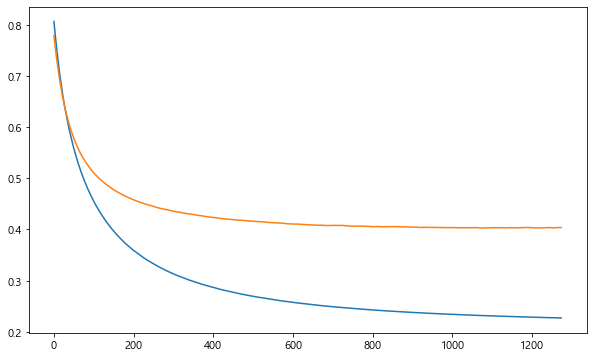

In [432]:
plt.plot(h3.history['loss'])
plt.plot(h3.history['val_loss'])

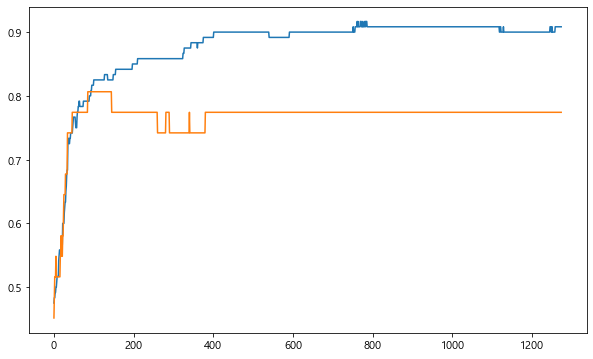

In [433]:
plt.plot(h3.history['accuracy'])
plt.plot(h3.history['val_accuracy'])

In [434]:
confusion_matrix(yv_train, (h3.model.predict(xv_train)>0.5)+0)

array([[46,  8],
       [ 3, 63]], dtype=int64)

In [435]:
f1_score(yv_train, (h3.model.predict(xv_train)>0.5)+0)

0.9197080291970803

In [436]:
accuracy_score(yv_train, (h3.model.predict(xv_train)>0.5)+0)

0.9083333333333333

In [437]:
r2_score(yv_train, (h3.model.predict(xv_train)>0.5)+0)

0.6296296296296298

In [451]:
result1 = (h1.model.predict(x_test) > 0.5) + 0
df_result1 = pd.DataFrame(result1, columns=['target'])
df_result1.insert(0, 'id', range(1,153))
df_result1.to_csv('result/result1.csv', index=False, encoding='cp949')

In [452]:
result2 = (h2.model.predict(x_test) > 0.5) + 0
df_result2 = pd.DataFrame(result2, columns=['target'])
df_result2.insert(0, 'id', range(1,153))
df_result2.to_csv('result/result2.csv', index=False, encoding='cp949')

In [453]:
result3 = (h3.model.predict(x_test) > 0.5) + 0
df_result3 = pd.DataFrame(result3, columns=['target'])
df_result3.insert(0, 'id', range(1,153))
df_result3.to_csv('result/result3.csv', index=False, encoding='cp949')